In [1]:
#the usuals
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import datetime
from datetime import timedelta
from math import sqrt
import importlib
from tqdm import tqdm

# plots
from matplotlib import style
style.use('default')

# Modeling
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from keras.callbacks import Callback
from keras.models import load_model


In [2]:
# Data between 2018 and 2024 
data_path = "Data/"
files = glob.glob(data_path + "load_and_weather_data*")
df = pd.read_csv(files[0])

In [3]:
df

,Unnamed: 0,timestamp,tmpc,relh,sped,feel,p01m,ERCOT
0,0,2018-01-01 01:00:00,-0.833333,91.393333,12.777778,20.792222,0.0,50567.069682
1,1,2018-01-01 02:00:00,-1.284444,90.400000,12.266667,20.203333,0.0,50617.087977
2,2,2018-01-01 03:00:00,-1.752222,91.590000,11.883333,19.276667,0.0,50694.300087
3,3,2018-01-01 04:00:00,-1.895556,90.946667,12.905556,18.685556,0.0,50999.591693
4,4,2018-01-01 05:00:00,-1.968889,89.366667,12.394444,18.707778,0.0,51723.732017
...,...,...,...,...,...,...,...,...
61363,61363,2024-12-31 20:00:00,10.124444,54.446667,3.577778,49.871111,0.0,47619.264355
61364,61364,2024-12-31 21:00:00,9.574444,63.366667,5.494444,47.508889,0.0,46737.678611
61365,61365,2024-12-31 22:00:00,8.994444,64.966667,6.388889,46.236667,0.0,45775.649767
61366,61366,2024-12-31 23:00:00,8.068889,65.713333,4.727778,45.061111,0.0,44779.606498


In [4]:
#filling missing values with linear interpolation
#PLEASE Interpolate only the columns you need -- you don't want timestamps col
#merged_df=merged_df.interpolate(method='linear')
df.columns
for col in df.columns:
    if col!='timestamp':
        #print(f'{col}')
        df[col] = df[col].interpolate(method='linear')

In [5]:
df=df.drop(columns='Unnamed: 0')

In [6]:
df

,timestamp,tmpc,relh,sped,feel,p01m,ERCOT
0,2018-01-01 01:00:00,-0.833333,91.393333,12.777778,20.792222,0.0,50567.069682
1,2018-01-01 02:00:00,-1.284444,90.400000,12.266667,20.203333,0.0,50617.087977
2,2018-01-01 03:00:00,-1.752222,91.590000,11.883333,19.276667,0.0,50694.300087
3,2018-01-01 04:00:00,-1.895556,90.946667,12.905556,18.685556,0.0,50999.591693
4,2018-01-01 05:00:00,-1.968889,89.366667,12.394444,18.707778,0.0,51723.732017
...,...,...,...,...,...,...,...
61363,2024-12-31 20:00:00,10.124444,54.446667,3.577778,49.871111,0.0,47619.264355
61364,2024-12-31 21:00:00,9.574444,63.366667,5.494444,47.508889,0.0,46737.678611
61365,2024-12-31 22:00:00,8.994444,64.966667,6.388889,46.236667,0.0,45775.649767
61366,2024-12-31 23:00:00,8.068889,65.713333,4.727778,45.061111,0.0,44779.606498


In [7]:
df.to_csv('Data/data_2018_2024.csv', index=False)

In [8]:
# Sort the DataFrame by index
df['timestamp']=pd.to_datetime(df.timestamp)
df.set_index('timestamp', inplace=True)
df = df.sort_index()

In [9]:
df

,tmpc,relh,sped,feel,p01m,ERCOT
timestamp,,,,,,
2018-01-01 01:00:00,-0.833333,91.393333,12.777778,20.792222,0.0,50567.069682
2018-01-01 02:00:00,-1.284444,90.400000,12.266667,20.203333,0.0,50617.087977
2018-01-01 03:00:00,-1.752222,91.590000,11.883333,19.276667,0.0,50694.300087
2018-01-01 04:00:00,-1.895556,90.946667,12.905556,18.685556,0.0,50999.591693
2018-01-01 05:00:00,-1.968889,89.366667,12.394444,18.707778,0.0,51723.732017
...,...,...,...,...,...,...
2024-12-31 20:00:00,10.124444,54.446667,3.577778,49.871111,0.0,47619.264355
2024-12-31 21:00:00,9.574444,63.366667,5.494444,47.508889,0.0,46737.678611
2024-12-31 22:00:00,8.994444,64.966667,6.388889,46.236667,0.0,45775.649767


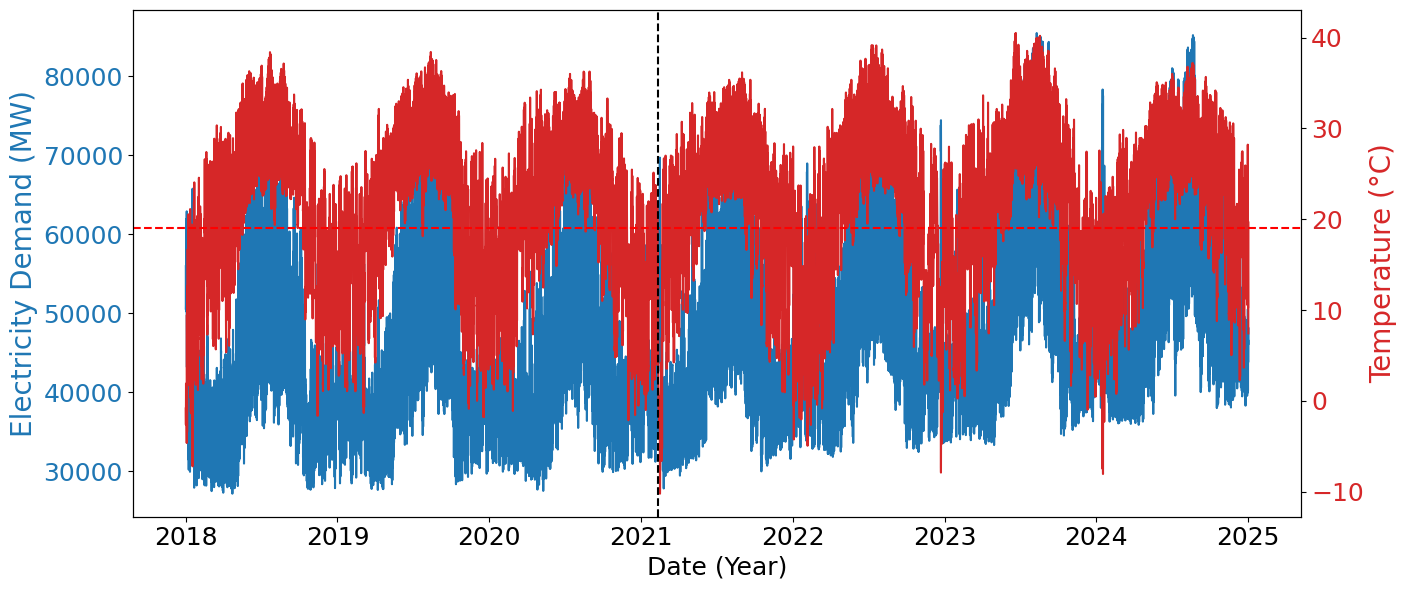

In [10]:
# Plot data
fig, ax1 = plt.subplots(figsize=(14,6), linewidth=2)

color = 'tab:blue'
ax1.set_xlabel('Date (Year)',fontsize=18)
ax1.set_ylabel('Electricity Demand (MW)', fontsize=20, color=color)
ax1.plot(df.index, df['ERCOT'], '-', color=color)
ax1.tick_params(axis='y',  labelsize=18, labelcolor=color)
ax1.tick_params(axis='x',  labelsize=18)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Temperature (°C)', fontsize=20,color=color)
ax2.plot(df.index, df['tmpc'], '-', color=color)
ax2.tick_params(axis='y',  labelsize=12, labelcolor=color)
# plt.xlim(datetime.datetime(2020, 5, 1), datetime.datetime(2020, 10, 1))
fig.tight_layout()
ax2.axhline(y=19, ls='--', color='red')
plt.axvline(x=datetime.datetime(2021,2,10,12,0,0), ls='--',color='black')

#plt.show()

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('Fig1_test_data.png', dpi=300, bbox_inches='tight')
# folder='C:/Users/sajib/Documents/Python_scripts/ERCOT_Electricity_Forecast-main/'
# # filename= folder +'Fig1_test_data.png'
# plt.savefig(filename,dpi=400, bbox_inches='tight', format='png')


In [11]:
def remove_nan(x0,y0):
    mask = ~np.isnan(x0) & ~np.isnan(y0)
    x=x0[mask]
    y=y0[mask]
    return x,y

In [12]:
def bin_averaged(x0,y0,bin_number,substract=0.1):
    from scipy import stats
    mask = ~np.isnan(x0) & ~np.isnan(y0)
    x=x0[mask]
    y=y0[mask]
    bins = np.linspace(np.min(x)-substract,np.max(x)-substract,bin_number)
    #bins = np.linspace(1,26,bin_number)
    bin_centers = (bins [:-1] + bins [1:])/2
    bin_mean_shear, bin_edges, binnumber = stats.binned_statistic(x,y, statistic='mean', bins=bins)
    bin_median_shear, bin_edges, binnumber = stats.binned_statistic(x,y, statistic='median', bins=bins)
    bin_std_shear, bin_edges, binnumber = stats.binned_statistic(x,y, statistic='std', bins=bins)
    return bin_centers, bin_mean_shear, bin_median_shear, bin_std_shear

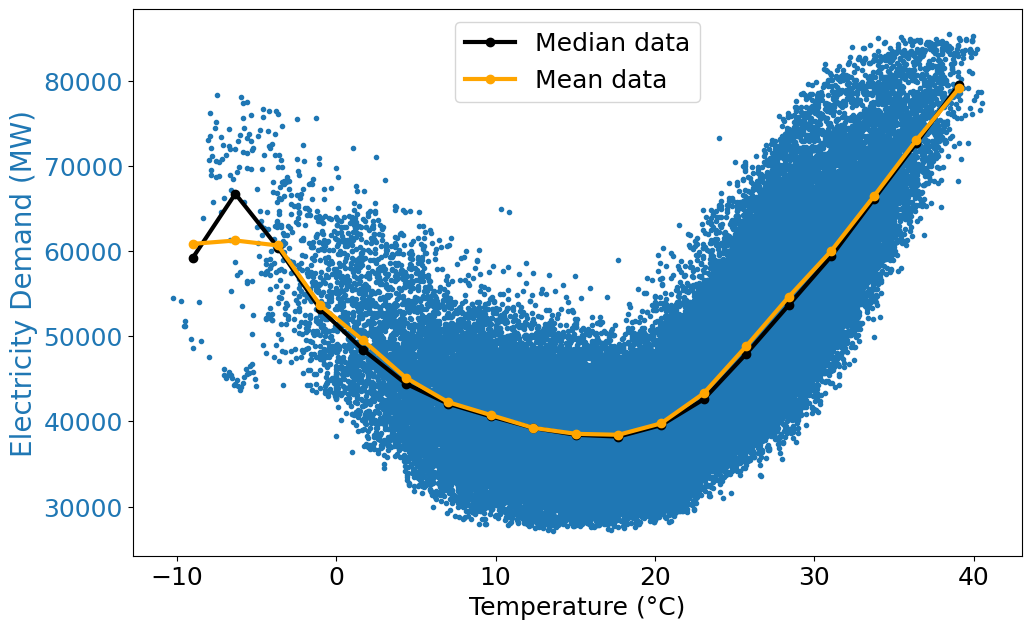

In [13]:
# Plot data
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.plot(df['tmpc'],df['ERCOT'], '.', color=color)
x=df['tmpc']
y=df['ERCOT']

bin_centers, bin_mean, bin_median, bin_std=bin_averaged(x,y,20,substract=0.1)

ax1.plot(bin_centers,bin_median,'-o', lw=3, color='Black', label='Median data')
ax1.plot(bin_centers,bin_mean,'-o', lw=3, color='orange', label='Mean data')


ax1.tick_params(axis='y', labelsize=16, labelcolor=color)
fig.tight_layout()
ax1.set_xlabel('Temperature (°C)',fontsize=18)
ax1.set_ylabel('Electricity Demand (MW)', fontsize=20, color=color)
#ax1.axhline(y=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
# Save the plot
plt.savefig('Relationship between electricity demand and air temperature.png', dpi=300, bbox_inches='tight')
# filename= folder +'Fig2_relation.png'
# plt.savefig(filename,dpi=400, bbox_inches='tight', format='png')

C:\Users\sajib\AppData\Local\Temp\ipykernel_2196\3146338686.py:34: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 0.0001)
C:\Users\sajib\AppData\Local\Temp\ipykernel_2196\3146338686.py:71: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 0.0001)


Text(2.3148148148148147e-05, 3, '12-hour')

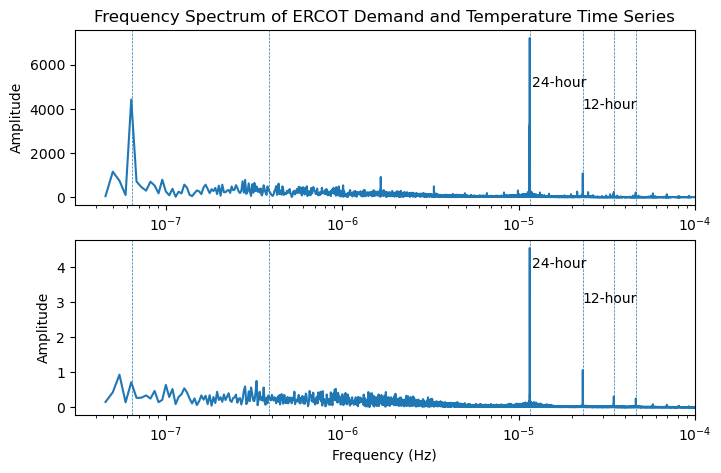

In [14]:
## Fast Fourier Transform (FFT)
## Spectral analysis

from scipy.fft import fft, fftfreq
fig=plt.figure(figsize=(8,5))

fig.add_subplot(211)
sampling_rate=1/(60*60)
N = len(df['tmpc'])  # Number of samples
N1=len(df['ERCOT'])
yf = fft(df['tmpc'].values) # Perform FFT
yf1=fft(df['ERCOT'].values) # Perform FFT
xf = fftfreq(N, 1/sampling_rate) # Get corresponding frequencies


# plt.plot(xf[10:N//2], 2.0/N * np.abs(yf[10:N//2])) # Plot positive frequencies and their magnitudes
plt.plot(xf[10:N//2], 2.0/N * np.abs(yf1[10:N//2])) # Plot positive frequencies and their magnitudes
plt.title('Frequency Spectrum of ERCOT Demand and Temperature Time Series')
# plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
# plt.grid(True)

plt.axvline(x=1/(24*182*3600), ls='--', lw=0.5)

plt.axvline(x=1/(24*30*3600), ls='--', lw=0.5)
plt.axvline(x=1/(24*3600), ls='--', lw=0.5)
plt.axvline(x=1/(12*3600), ls='--', lw=0.5)

plt.axvline(x=1/(8*3600), ls='--', lw=0.5)
plt.axvline(x=1/(6*3600), ls='--', lw=0.5)


plt.xscale('log')
plt.xlim(0, 0.0001)

plt.text(1.184074074074073e-05, 5000, '24-hour')
plt.text(2.3148148148148147e-05, 4000, '12-hour')




fig.add_subplot(212)
sampling_rate=1/(60*60)
N = len(df['tmpc'])  # Number of samples
N1=len(df['ERCOT'])
yf = fft(df['tmpc'].values) # Perform FFT
yf1=fft(df['ERCOT'].values) # Perform FFT
xf = fftfreq(N, 1/sampling_rate) # Get corresponding frequencies



plt.plot(xf[10:N//2], 2.0/N * np.abs(yf[10:N//2])) # Plot positive frequencies and their magnitudes
# plt.plot(xf[10:N//2], 2.0/N * np.abs(yf1[10:N//2])) # Plot positive frequencies and their magnitudes
# plt.title('Frequency Spectrum of Time Series')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
# plt.grid(True)


plt.axvline(x=1/(24*182*3600), ls='--', lw=0.5)

plt.axvline(x=1/(24*30*3600), ls='--', lw=0.5)
plt.axvline(x=1/(24*3600), ls='--', lw=0.5)
plt.axvline(x=1/(12*3600), ls='--', lw=0.5)

plt.axvline(x=1/(8*3600), ls='--', lw=0.5)
plt.axvline(x=1/(6*3600), ls='--', lw=0.5)


plt.xscale('log')
plt.xlim(0, 0.0001)

plt.text(1.184074074074073e-05, 4, '24-hour')
plt.text(2.3148148148148147e-05, 3, '12-hour')
# plt.savefig('Frequency Spectrum of Time Series.png', dpi=300, bbox_inches='tight')


## Identify the extreme events

In [16]:
df['ERCOT']

timestamp
2018-01-01 01:00:00    50567.069682
2018-01-01 02:00:00    50617.087977
2018-01-01 03:00:00    50694.300087
2018-01-01 04:00:00    50999.591693
2018-01-01 05:00:00    51723.732017
                           ...     
2024-12-31 20:00:00    47619.264355
2024-12-31 21:00:00    46737.678611
2024-12-31 22:00:00    45775.649767
2024-12-31 23:00:00    44779.606498
2025-01-01 00:00:00    43892.434849
Name: ERCOT, Length: 61368, dtype: float64

In [17]:

def hampel_filter(data, window_size, n_sigmas=3):
    """
    Detects outliers in a time series using the Hampel filter.

    Args:
        data (pd.Series): Time series data.
        window_size (int): Size of the sliding window.
        n_sigmas (float): Number of standard deviations (expressed as MAD) to flag outliers.

    Returns:
        pd.Series: Boolean series indicating outliers (True) and non-outliers (False).
    """
    
    data_pandas = pd.Series(data)
    
    half_window = window_size // 2
    
    medians = data_pandas.rolling(window_size, center=True).median()
    
    mad = lambda x: np.median(np.abs(x - np.median(x)))
    mads = data_pandas.rolling(window_size, center=True).apply(mad, raw=True)
    
    thresholds = n_sigmas * 1.4826 * mads
    
    outliers = np.abs(data_pandas - medians) > thresholds
    
    return outliers

In [18]:
df

,tmpc,relh,sped,feel,p01m,ERCOT
timestamp,,,,,,
2018-01-01 01:00:00,-0.833333,91.393333,12.777778,20.792222,0.0,50567.069682
2018-01-01 02:00:00,-1.284444,90.400000,12.266667,20.203333,0.0,50617.087977
2018-01-01 03:00:00,-1.752222,91.590000,11.883333,19.276667,0.0,50694.300087
2018-01-01 04:00:00,-1.895556,90.946667,12.905556,18.685556,0.0,50999.591693
2018-01-01 05:00:00,-1.968889,89.366667,12.394444,18.707778,0.0,51723.732017
...,...,...,...,...,...,...
2024-12-31 20:00:00,10.124444,54.446667,3.577778,49.871111,0.0,47619.264355
2024-12-31 21:00:00,9.574444,63.366667,5.494444,47.508889,0.0,46737.678611
2024-12-31 22:00:00,8.994444,64.966667,6.388889,46.236667,0.0,45775.649767


In [19]:
df_mean = df['ERCOT'].resample('Y',closed='left').mean()

C:\Users\sajib\AppData\Local\Temp\ipykernel_2196\1941758236.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_mean = df['ERCOT'].resample('Y',closed='left').mean()


In [20]:
df_mean.index=df_mean.index -timedelta(days=180, hours=0, minutes=0)

In [21]:
df_mean

timestamp
2018-07-04    42959.751078
2019-07-04    43813.352643
2020-07-04    43451.493351
2021-07-04    44842.212728
2022-07-04    49079.249327
2023-07-04    50732.764514
2024-07-04    52534.667565
2025-07-04    44821.939471
Name: ERCOT, dtype: float64

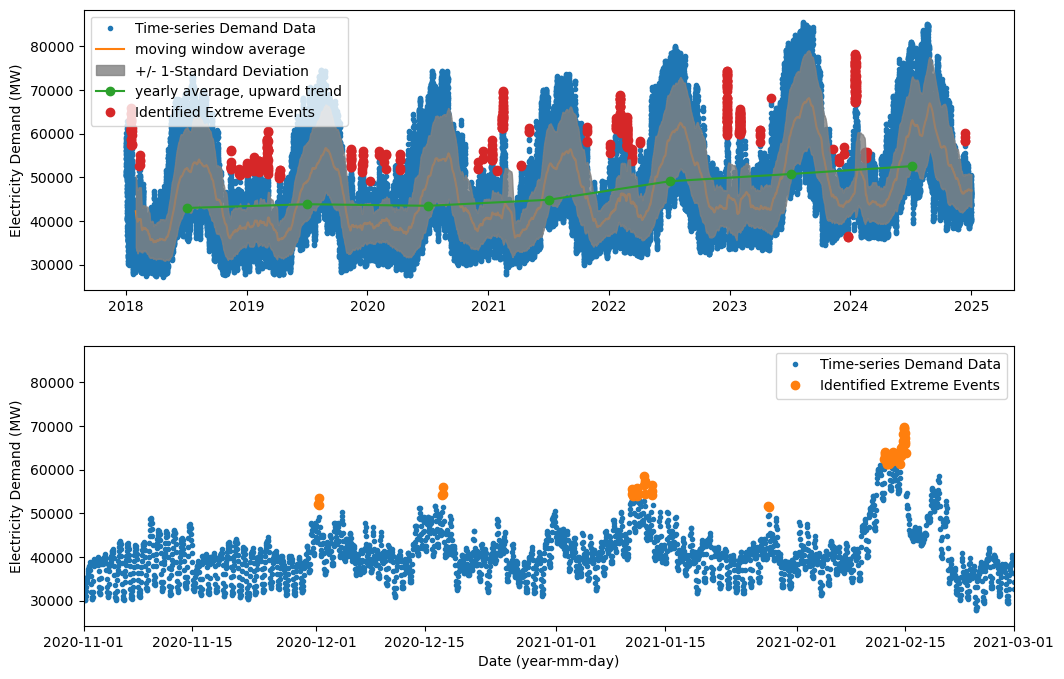

In [22]:
window_size = 24*30 # Define the window size for the moving average
df['ERCOT_avg'] = df['ERCOT'].rolling(window=window_size).mean()
df['ERCOT_std'] = df['ERCOT'].rolling(window=window_size).std()

fig=plt.figure(figsize=(12,8))
fig.add_subplot(211)
plt.plot(df['ERCOT'],'.', label='Time-series Demand Data', zorder=1)
plt.plot(df['ERCOT_avg'],label='moving window average', zorder=1)

plt.fill_between(df['ERCOT'].index, df['ERCOT_avg'] - df['ERCOT_std'], df['ERCOT_avg'] + df['ERCOT_std'], color='gray', alpha=0.8, label='+/- 1-Standard Deviation', zorder=2)

plt.plot(df_mean[:-1],'o-', label='yearly average, upward trend')

kk=hampel_filter(df['ERCOT'], window_size=30*24, n_sigmas=3)
plt.plot(df['ERCOT'][kk],'o', label='Identified Extreme Events',zorder=1)

plt.ylabel('Electricity Demand (MW)')
plt.legend()
fig.add_subplot(212)
plt.plot(df['ERCOT'],'.', label='Time-series Demand Data')
kk=hampel_filter(df['ERCOT'], window_size=30*24, n_sigmas=3)
plt.plot(df['ERCOT'][kk],'o', label='Identified Extreme Events')

plt.ylabel('Electricity Demand (MW)')
plt.xlabel('Date (year-mm-day)')
plt.xlim(datetime.datetime(2020,11,1), datetime.datetime(2021,3,1) )
plt.legend()
# plt.savefig('extreme_event_time_series.png', dpi=300, bbox_inches='tight')


           tmpc      relh      sped      feel      p01m     ERCOT
tmpc   1.000000 -0.244046  0.208207  0.990866  0.005110  0.554567
relh  -0.244046  1.000000 -0.380788 -0.238147  0.047748 -0.296505
sped   0.208207 -0.380788  1.000000  0.192490  0.055149  0.163689
feel   0.990866 -0.238147  0.192490  1.000000  0.006351  0.584560
p01m   0.005110  0.047748  0.055149  0.006351  1.000000 -0.007759
ERCOT  0.554567 -0.296505  0.163689  0.584560 -0.007759  1.000000


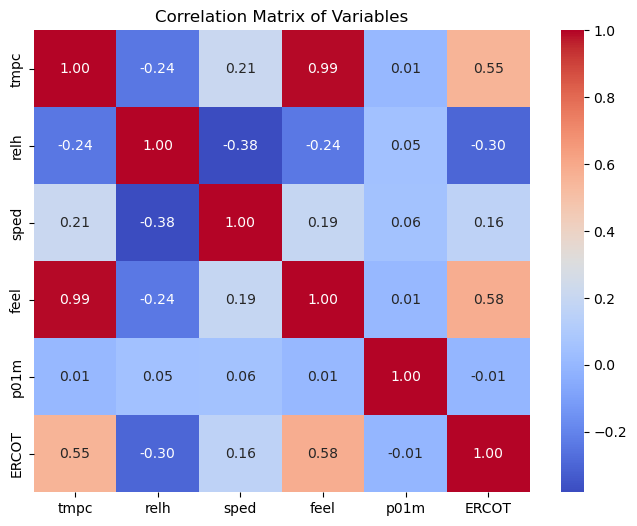

In [23]:
df=df.drop(columns=['ERCOT_avg', 'ERCOT_std'])
correlation_matrix = df.corr()
print(correlation_matrix)
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6)) # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Variables')
# Save the plot
# plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## Load the dataset

In [116]:
df2 = pd.read_csv('Data/data_2018_2024.csv')

In [118]:
df2

,timestamp,tmpc,relh,sped,feel,p01m,ERCOT
0,2018-01-01 01:00:00,-0.833333,91.393333,12.777778,20.792222,0.0,50567.069682
1,2018-01-01 02:00:00,-1.284444,90.400000,12.266667,20.203333,0.0,50617.087977
2,2018-01-01 03:00:00,-1.752222,91.590000,11.883333,19.276667,0.0,50694.300087
3,2018-01-01 04:00:00,-1.895556,90.946667,12.905556,18.685556,0.0,50999.591693
4,2018-01-01 05:00:00,-1.968889,89.366667,12.394444,18.707778,0.0,51723.732017
...,...,...,...,...,...,...,...
61363,2024-12-31 20:00:00,10.124444,54.446667,3.577778,49.871111,0.0,47619.264355
61364,2024-12-31 21:00:00,9.574444,63.366667,5.494444,47.508889,0.0,46737.678611
61365,2024-12-31 22:00:00,8.994444,64.966667,6.388889,46.236667,0.0,45775.649767
61366,2024-12-31 23:00:00,8.068889,65.713333,4.727778,45.061111,0.0,44779.606498


In [120]:
import pandas as pd
import numpy as np

# df2 = pd.read_csv('Data/data_2018_2024.csv')

# Ensure 'timestamp' is a datetime object and set as index for easier lagging
df2['timestamp'] = pd.to_datetime(df2['timestamp'])
df2 = df2.set_index('timestamp')

# Define the maximum number of lags you want to consider
# Let's start with 6 lags, similar to the paper's L(d-6)
max_lags = 6

# Create lagged ERCOT load columns
for i in range(1, max_lags + 1):
    df2[f'ERCOT_lag_{i}'] = df2['ERCOT'].shift(i)

# Now, calculate the correlation matrix for ERCOT and its lags
# We'll drop rows with NaNs that result from shifting (first 'max_lags' rows)
correlation_data = df2[['ERCOT'] + [f'ERCOT_lag_{i}' for i in range(1, max_lags + 1)]].dropna()

# Calculate the Pearson correlation matrix
correlation_matrix = correlation_data.corr(method='pearson')

# Extract the correlations of 'ERCOT' with itself and its lags
# This will be the first row of the correlation_matrix
# Renaming for clarity and similarity to the paper
correlation_series = correlation_matrix['ERCOT']
correlation_series = correlation_series.rename(index={'ERCOT': 'ERCOT(d)'})
for i in range(1, max_lags + 1):
    correlation_series = correlation_series.rename(index={f'ERCOT_lag_{i}': f'ERCOT(d-{i})'})

# We need to construct a DataFrame that looks like Table 2
# Let's create a list of columns we want to correlate
cols_to_correlate = ['ERCOT'] + [f'ERCOT_lag_{i}' for i in range(1, max_lags + 1)]
renamed_cols_for_display = [f'ERCOT(d-{i})' if i > 0 else 'ERCOT(d)' for i in range(max_lags + 1)]
correlation_df = pd.DataFrame(index=renamed_cols_for_display, columns=renamed_cols_for_display)

for i, row_label in enumerate(renamed_cols_for_display):
    for j, col_label in enumerate(renamed_cols_for_display):
        # Calculate correlation between col_to_correlate[i] and col_to_correlate[j]
        # Make sure to handle NaNs by dropping them for each pair-wise calculation if necessary
        # Or, just use the full correlation_matrix if it was computed on clean data
        if row_label == col_label:
            correlation_df.loc[row_label, col_label] = 1.0
        else:
            # We already have the full correlation_matrix
            original_row_col = cols_to_correlate[i]
            original_col_col = cols_to_correlate[j]
            correlation_df.loc[row_label, col_label] = correlation_matrix.loc[original_row_col, original_col_col]

# # Display the table
# print("Table: Pearson correlation coefficient of ERCOT load in different hours.")
# print(correlation_df.round(3)) # Round to 3 decimal places for display

# You'll also want to determine statistical significance (like the '**' in the paper).
# This typically involves calculating p-values for each correlation.
# For large datasets, most correlations will be statistically significant.
# You can use scipy.stats.pearsonr to get the p-value.

from scipy.stats import pearsonr

# Function to get correlation and p-value formatted
def get_corr_string(series1, series2):
    corr, p_value = pearsonr(series1.dropna(), series2.dropna())
    if p_value < 0.01: # Check for significance at 0.01 level
        return f"{corr:.3f} **"
    elif p_value < 0.05: # Check for significance at 0.05 level
        return f"{corr:.3f} *"
    else:
        return f"{corr:.3f}"

# Re-create the table including significance stars
correlation_df_str = pd.DataFrame(index=renamed_cols_for_display, columns=renamed_cols_for_display, dtype=object)

for i, row_label in enumerate(renamed_cols_for_display):
    for j, col_label in enumerate(renamed_cols_for_display):
        if i == j: # Diagonal elements are always 1
            correlation_df_str.loc[row_label, col_label] = "1"
        else:
            s1 = correlation_data[cols_to_correlate[i]]
            s2 = correlation_data[cols_to_correlate[j]]
            correlation_df_str.loc[row_label, col_label] = get_corr_string(s1, s2)

In [122]:
correlation_df_str

,ERCOT(d),ERCOT(d-1),ERCOT(d-2),ERCOT(d-3),ERCOT(d-4),ERCOT(d-5),ERCOT(d-6)
ERCOT(d),1,0.985 **,0.944 **,0.882 **,0.804 **,0.717 **,0.627 **
ERCOT(d-1),0.985 **,1,0.985 **,0.944 **,0.882 **,0.804 **,0.717 **
ERCOT(d-2),0.944 **,0.985 **,1,0.985 **,0.944 **,0.882 **,0.804 **
ERCOT(d-3),0.882 **,0.944 **,0.985 **,1,0.985 **,0.944 **,0.882 **
ERCOT(d-4),0.804 **,0.882 **,0.944 **,0.985 **,1,0.985 **,0.944 **
ERCOT(d-5),0.717 **,0.804 **,0.882 **,0.944 **,0.985 **,1,0.985 **
ERCOT(d-6),0.627 **,0.717 **,0.804 **,0.882 **,0.944 **,0.985 **,1


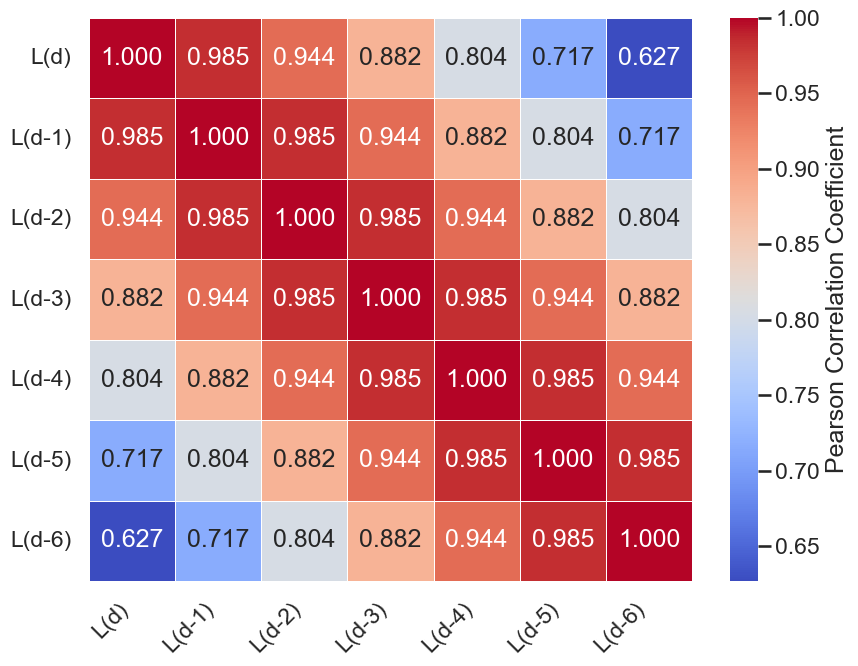

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Define the maximum number of lags you want to consider
max_lags = 6

# Create lagged ERCOT load columns
for i in range(1, max_lags + 1):
    df2[f'ERCOT_lag_{i}'] = df2['ERCOT'].shift(i)

# Now, calculate the correlation matrix for ERCOT and its lags
correlation_data = df2[['ERCOT'] + [f'ERCOT_lag_{i}' for i in range(1, max_lags + 1)]].dropna()

# Calculate the Pearson correlation matrix (numerical values)
correlation_matrix = correlation_data.corr(method='pearson')

# --- Re-construct correlation_df for plotting (numerical values) ---
cols_to_correlate = ['ERCOT'] + [f'ERCOT_lag_{i}' for i in range(1, max_lags + 1)]
# renamed_cols_for_display = [f'ERCOT(d-{i})' if i > 0 else 'ERCOT(d)' for i in range(max_lags + 1)]
renamed_cols_for_display = [f'L(d-{i})' if i > 0 else 'L(d)' for i in range(max_lags + 1)]
correlation_df = pd.DataFrame(index=renamed_cols_for_display, columns=renamed_cols_for_display)

for i, row_label in enumerate(renamed_cols_for_display):
    for j, col_label in enumerate(renamed_cols_for_display):
        if row_label == col_label:
            correlation_df.loc[row_label, col_label] = 1.0
        else:
            original_row_col = cols_to_correlate[i]
            original_col_col = cols_to_correlate[j]
            correlation_df.loc[row_label, col_label] = correlation_matrix.loc[original_row_col, original_col_col]

# Convert to float to ensure seaborn handles it correctly
correlation_df = correlation_df.astype(float)

# --- Plotting the Correlation Heatmap ---

plt.figure(figsize=(9, 7)) # Adjust figure size as needed
sns.heatmap(
    correlation_df,
    annot=True,       # Show the correlation values on the heatmap
    fmt=".3f",        # Format the annotations to 3 decimal places
    cmap='coolwarm',  # Choose a color map (coolwarm is good for correlations: red for negative, blue for positive)
    linewidths=.5,    # Add lines between cells for better separation
    cbar_kws={'label': 'Pearson Correlation Coefficient'} # Label for the color bar
)
# plt.title('Pearson Correlation Matrix of ERCOT Load (Current vs. Lagged Hours)', fontsize=14)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.yticks(rotation=0)            # Keep y-axis labels horizontal
plt.tight_layout()                # Adjust layout to prevent labels from overlapping
plt.savefig('Plots/pearson_correlation_coefficient.png', dpi=300, bbox_inches='tight')
plt.show()

# --- (Optional: If you still want to print the text table with stars, include the previous code here) ---
# Function to get correlation and p-value formatted
def get_corr_string(series1, series2):
    # Ensure no NaN values are passed to pearsonr
    combined_df = pd.DataFrame({'s1': series1, 's2': series2}).dropna()
    if combined_df.empty:
        return "NaN" # Handle cases where there's no data for correlation
    corr, p_value = pearsonr(combined_df['s1'], combined_df['s2'])
    if p_value < 0.01: # Check for significance at 0.01 level
        return f"{corr:.3f} **"
    elif p_value < 0.05: # Check for significance at 0.05 level
        return f"{corr:.3f} *"
    else:
        return f"{corr:.3f}"

# Re-create the table including significance stars (for printing, not plotting)
correlation_df_str = pd.DataFrame(index=renamed_cols_for_display, columns=renamed_cols_for_display, dtype=object)

for i, row_label in enumerate(renamed_cols_for_display):
    for j, col_label in enumerate(renamed_cols_for_display):
        if i == j: # Diagonal elements are always 1
            correlation_df_str.loc[row_label, col_label] = "1"
        else:
            s1 = correlation_data[cols_to_correlate[i]]
            s2 = correlation_data[cols_to_correlate[j]]
            correlation_df_str.loc[row_label, col_label] = get_corr_string(s1, s2)


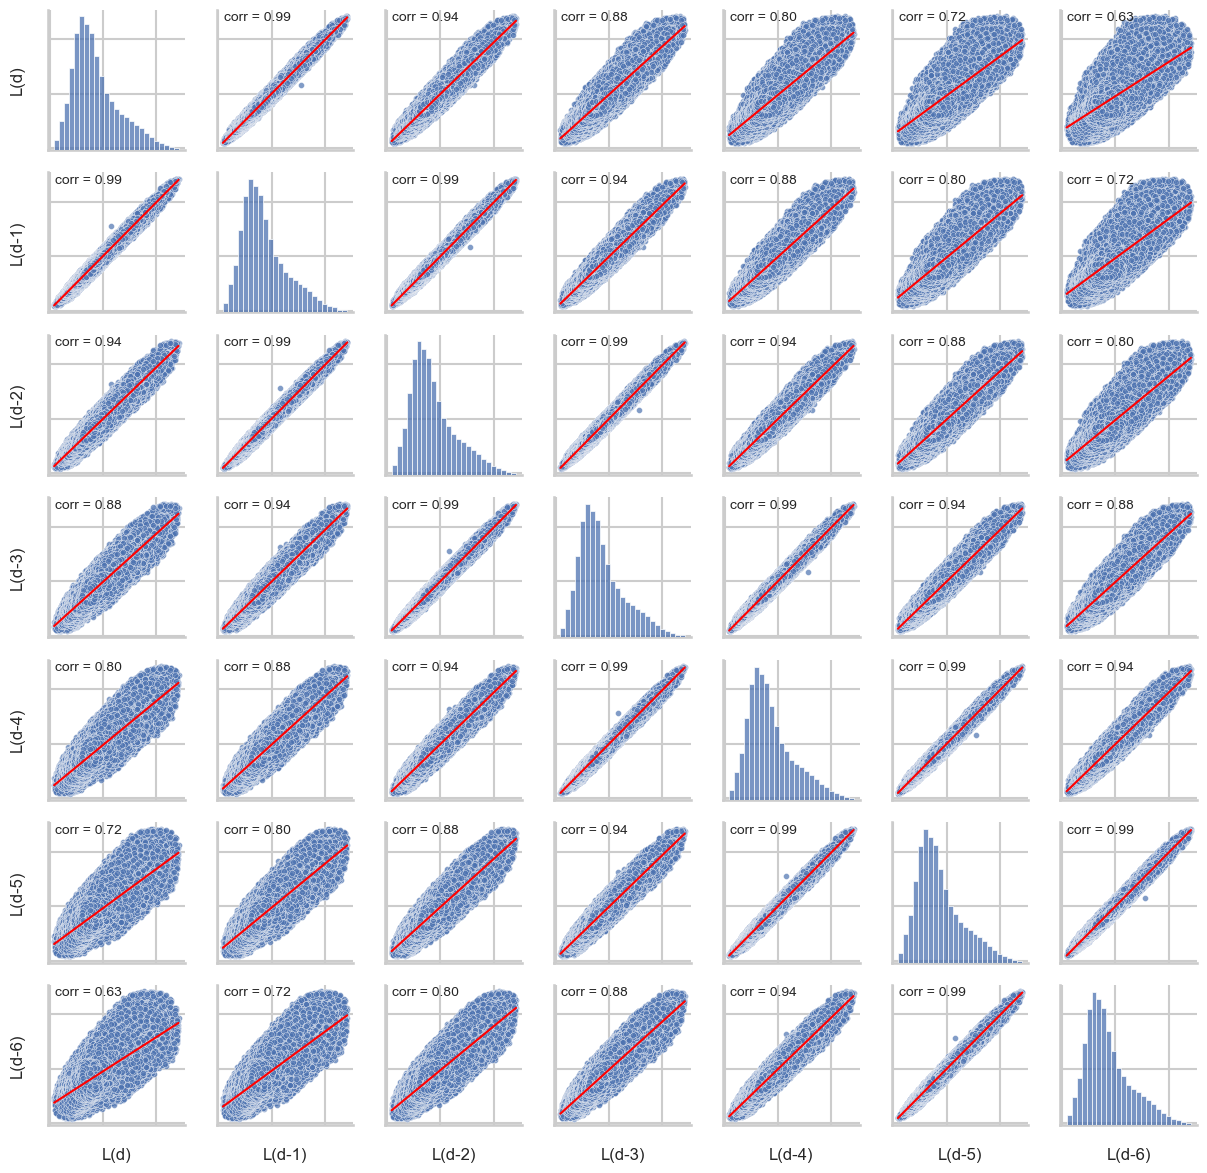

In [132]:
# --- Symmetric Pair Plot for ERCOT & Lags with clean axis labels ---
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Rename columns already done with col_map
plot_df = correlation_data[cols_to_correlate].rename(columns=col_map).dropna().copy()

sns.set_theme(style="whitegrid", context="talk")

def add_corr_text(x, y):
    r, _ = pearsonr(x, y)
    ax = plt.gca()
    ax.text(0.05, 0.92, f"corr = {r:.2f}", transform=ax.transAxes, fontsize=10)

def scatter_with_reg(x, y, **kws):
    ax = plt.gca()
    sns.scatterplot(x=x, y=y, s=18, alpha=0.7, ax=ax)
    sns.regplot(x=x, y=y, scatter=False, ax=ax, color="red", line_kws={"lw": 1.5})
    add_corr_text(x, y)

g = sns.PairGrid(plot_df, diag_sharey=False, corner=False)

# Diagonal histograms
g.map_diag(sns.histplot, bins=25, edgecolor="white")

# Scatter + regression off-diagonal
g.map_offdiag(scatter_with_reg)

# Clean up axis tick labels (show only variable names, not raw demand values)
for ax in g.axes.flatten():
    if ax is not None:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xlabel("")
        ax.set_ylabel("")

# Add back variable names on the outer edges only
for i, col in enumerate(plot_df.columns):
    g.axes[-1, i].set_xlabel(col, fontsize=12)   # bottom row x-labels
    g.axes[i, 0].set_ylabel(col, fontsize=12)   # left col y-labels

# Title & layout
plt.subplots_adjust(top=0.94)
# g.fig.suptitle("Symmetric Pair Plot with Regression Lines and Correlation", fontsize=14)

k = len(plot_df.columns)
side = max(12, 1.8 * k)
g.fig.set_size_inches(side, side)

# Save & show
g.fig.savefig("Plots/ercot_lag_pairplot_clean.png", dpi=300, bbox_inches="tight")
plt.show()


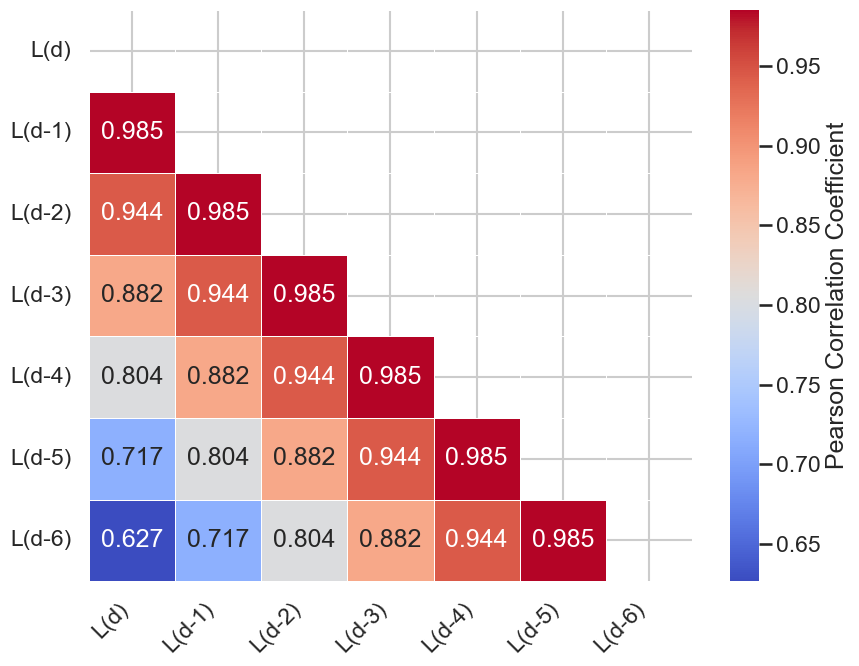

In [127]:
# --- Optional: Upper-triangle Pearson heatmap ---
import numpy as np

plt.figure(figsize=(9, 7))
mask = np.triu(np.ones_like(correlation_df, dtype=bool))
sns.heatmap(
    correlation_df,
    mask=mask,
    annot=True, fmt=".3f",
    cmap="coolwarm",
    linewidths=.5,
    cbar_kws={"label": "Pearson Correlation Coefficient"}
)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("Plots/ercot_lag_pearson_upper.png", dpi=300, bbox_inches="tight")
plt.show()


In [30]:
!pip install holidays

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import holidays # You might need to install this: pip install holidays

# --- 1. Load and Prepare Data (assuming df2 is already loaded from previous steps) ---
df2 = pd.read_csv('Data/data_2018_2024.csv') # Uncomment if running standalone
df2['timestamp'] = pd.to_datetime(df2['timestamp'])
df2 = df2.set_index('timestamp')

# Ensure the index is sorted to avoid issues
df2 = df2.sort_index()

# --- 2. Create Temporal Features ---
df2['M-label'] = df2.index.month # Month (1-12)
df2['W-label'] = df2.index.dayofweek + 1 # Weekday (1=Monday, ..., 7=Sunday)

# Create a Holiday Label (H-label)
us_holidays = holidays.US(years=range(2018, 2026)) # Adjust years to match your data range
df2['H-label'] = df2.index.map(lambda x: 1 if x.date() in us_holidays else 0)

# --- 3. Derive Daily Max-T and Min-T and Broadcast to Hourly Data ---
# Calculate daily max and min temperature
daily_max_temp = df2['tmpc'].resample('D').max().rename('Max-T')
daily_min_temp = df2['tmpc'].resample('D').min().rename('Min-T')

# Create a daily DataFrame from these aggregated values
daily_temps_df = pd.DataFrame({'Max-T': daily_max_temp, 'Min-T': daily_min_temp})

# Merge daily max/min temperatures back to the hourly DataFrame
df2['date_only'] = df2.index.normalize()
df2 = df2.merge(daily_temps_df, left_on='date_only', right_index=True, how='left')
df2 = df2.drop(columns=['date_only']) # Drop the temporary date_only column

# --- 4. ADD W-DATA HERE ---
# IMPORTANT: You need to replace this placeholder with your actual W-data logic.
# If 'W-data' is already a column in your df2 (e.g., from original CSV),
# then this line is not needed, and you just ensure its name is consistent below.
# If you need to derive it from other columns (tmpc, relh, sped, p01m),
# you'll put that derivation logic here.
# For demonstration, I'll create a dummy W-data column (replace this!)
# For correlation, this column needs to be numerical.
df2['W-data_dummy'] = np.random.randint(1, 5, size=len(df2)) # REPLACE THIS DUMMY DATA

# --- 5. Select & Rename Columns to Match Your Paper's Table 2 ---
df2 = df2.rename(columns={'ERCOT': 'L'}) # Rename ERCOT to L

# Now, select the columns for correlation (removed Relh, Speed, Feel, POIm)
features_for_correlation = [
    'L',
    'Max-T',
    'Min-T',
    'W-data_dummy', # W-data
    'M-label',
    'W-label',
    'H-label'
]

# Create a correlation-specific DataFrame with consistent names
correlation_df_clean = df2[features_for_correlation].copy()

# Rename W-data_dummy to W-data
correlation_df_clean = correlation_df_clean.rename(columns={
    'W-data_dummy': 'W-data'
})

# Drop any rows with NaN values that might arise from the merge or original data
correlation_df_clean = correlation_df_clean.dropna()

# Define the final order of factors for display in the table/heatmap
ordered_factors = [
    'L',
    'Max-T',
    'Min-T',
    'W-data',
    'M-label',
    'W-label',
    'H-label'
]

# Ensure the DataFrame is ordered correctly for correlation matrix
correlation_df_clean = correlation_df_clean[ordered_factors]

# --- 6. Calculate Spearman Correlation Matrix ---
spearman_correlation_matrix = correlation_df_clean.corr(method='spearman')

# --- 7. Present as a Table (Similar to Table 3 in the example paper) ---

# Function to get correlation and p-value formatted (for printing the table with stars)
def get_spearman_corr_string(series1, series2):
    valid_data = pd.DataFrame({'s1': series1, 's2': series2}).dropna()
    if valid_data.empty or len(valid_data) < 2:
        return "NaN"
    try:
        corr, p_value = spearmanr(valid_data['s1'], valid_data['s2'])
        if p_value < 0.01:
            return f"{corr:.3f} **"
        elif p_value < 0.05:
            return f"{corr:.3f} *"
        else:
            return f"{corr:.3f}"
    except ValueError:
        return "NaN"

# Create a DataFrame for printing the formatted table with stars
spearman_correlation_df_str = pd.DataFrame(index=ordered_factors, columns=ordered_factors, dtype=object)

for r_factor in ordered_factors:
    for c_factor in ordered_factors:
        if r_factor == c_factor:
            spearman_correlation_df_str.loc[r_factor, c_factor] = "1.000"
        else:
            s1 = correlation_df_clean[r_factor]
            s2 = correlation_df_clean[c_factor]
            spearman_correlation_df_str.loc[r_factor, c_factor] = get_spearman_corr_string(s1, s2)


In [32]:
spearman_correlation_df_str

,L,Max-T,Min-T,W-data,M-label,W-label,H-label
L,1.000,0.520 **,0.502 **,0.001,0.127 **,-0.076 **,-0.011 **
Max-T,0.520 **,1.000,0.895 **,-0.001,0.188 **,-0.004,-0.038 **
Min-T,0.502 **,0.895 **,1.000,-0.001,0.169 **,-0.017 **,-0.030 **
W-data,0.001,-0.001,-0.001,1.000,0.000,0.004,0.005
M-label,0.127 **,0.188 **,0.169 **,0.000,1.000,0.002,0.028 **
W-label,-0.076 **,-0.004,-0.017 **,0.004,0.002,1.000,-0.131 **
H-label,-0.011 **,-0.038 **,-0.030 **,0.005,0.028 **,-0.131 **,1.000


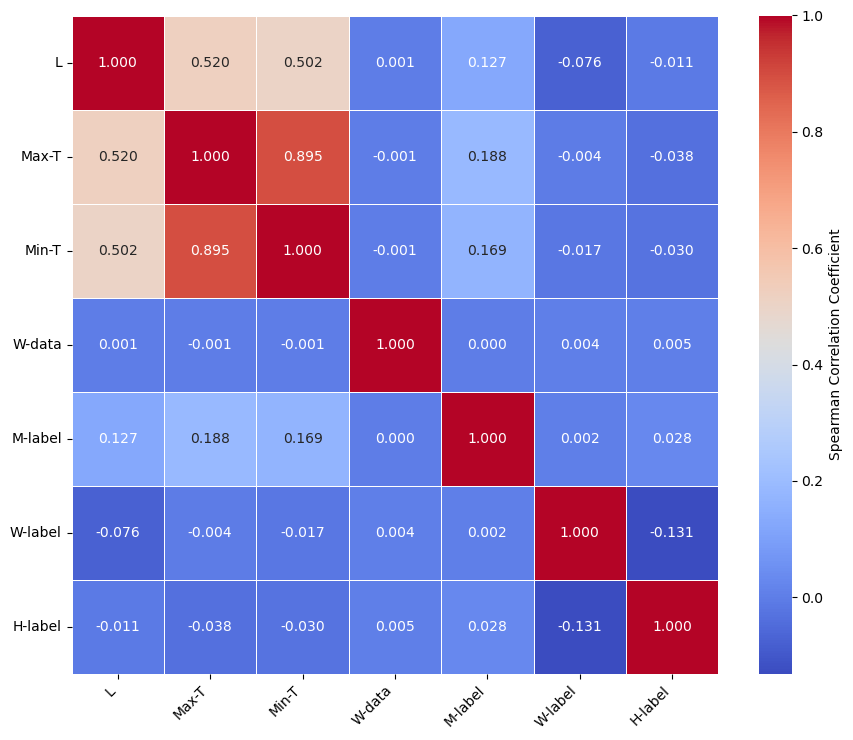


--- Summary of Analysis ---
This analysis provides the Spearman correlation coefficients between hourly electricity load ('L')
and selected meteorological and temporal factors, as outlined in your dataset description.
The table and heatmap highlight the strength and direction of monotonic relationships.
Factors with high absolute correlation coefficients (close to 1 or -1) are strong candidates
for input features in your electricity load forecasting model.


In [33]:
# --- 8. Plotting the Spearman Correlation Heatmap ---

# Ensure numerical matrix for plotting
spearman_correlation_matrix_for_plot = spearman_correlation_matrix.astype(float)

plt.figure(figsize=(9, 7.5)) # Adjust figure size for fewer factors
sns.heatmap(
    spearman_correlation_matrix_for_plot,
    annot=True,
    fmt=".3f",
    cmap='coolwarm',
    linewidths=.5,
    cbar_kws={'label': 'Spearman Correlation Coefficient'}
)
# plt.title('Spearman Correlation Matrix of Electricity Load and Influential Factors', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('Plots/spearman_correlation_coefficient.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n--- Summary of Analysis ---")
print("This analysis provides the Spearman correlation coefficients between hourly electricity load ('L')")
print("and selected meteorological and temporal factors, as outlined in your dataset description.")
print("The table and heatmap highlight the strength and direction of monotonic relationships.")
print("Factors with high absolute correlation coefficients (close to 1 or -1) are strong candidates")
print("for input features in your electricity load forecasting model.")

In [34]:
import pandas as pd

try:
    df2 = pd.read_csv('Data/data_2018_2024.csv')
except FileNotFoundError:
    print("Error: The file 'Data/data_2018_2024.csv' was not found.")
    print("Please check the file path and ensure it's correct.")
    exit() # Exit the script if the file isn't found


print("Columns in df2 after loading:")
print(df2.columns)

print("\nFirst 5 rows of df2:")
print(df2.head())


df2.columns = df2.columns.str.strip() # This removes leading/trailing spaces from all column names

# Now, try to proceed with your original logic, which should now work if 'timestamp' is truly there.
# If 'timestamp' exists after stripping, this section will run.
if 'timestamp' in df2.columns:
    # Ensure the 'timestamp' column is in datetime format
    df2['timestamp'] = pd.to_datetime(df2['timestamp'])

    # Set the 'timestamp' column as the DataFrame index
    df2 = df2.set_index('timestamp')

    # List of features to process
    features_to_process = ["tmpc", "relh", "sped", "feel"]

    # Dictionary to store the daily max/min stats for each feature
    all_daily_stats = {}

    for feature in features_to_process:
        # Check if the feature column actually exists before processing
        if feature in df2.columns:
            daily_stats = df2[feature].resample('D').agg(['max', 'min'])
            daily_stats.rename(columns={'max': f'Daily max {feature}', 'min': f'Daily min {feature}'}, inplace=True)
            all_daily_stats[feature] = daily_stats
        else:
            print(f"Warning: Column '{feature}' not found in DataFrame. Skipping.")

    # Combine all the daily stats into a single DataFrame
    if all_daily_stats: # Only concatenate if there's data to concatenate
        final_daily_summary = pd.concat([stats_df for stats_df in all_daily_stats.values()], axis=1)
        # Print the first few rows of the combined result
        print("\nFinal Daily Summary:")
        print(final_daily_summary.head())
    else:
        print("\nNo daily statistics could be generated as no valid feature columns were found.")

else:
    print("\n'timestamp' column still not found after attempting to strip spaces. Please check your CSV file's exact column names.")

Columns in df2 after loading:
Index(['timestamp', 'tmpc', 'relh', 'sped', 'feel', 'p01m', 'ERCOT'], dtype='object')

First 5 rows of df2:
             timestamp      tmpc       relh       sped       feel  p01m  \
0  2018-01-01 01:00:00 -0.833333  91.393333  12.777778  20.792222   0.0   
1  2018-01-01 02:00:00 -1.284444  90.400000  12.266667  20.203333   0.0   
2  2018-01-01 03:00:00 -1.752222  91.590000  11.883333  19.276667   0.0   
3  2018-01-01 04:00:00 -1.895556  90.946667  12.905556  18.685556   0.0   
4  2018-01-01 05:00:00 -1.968889  89.366667  12.394444  18.707778   0.0   

          ERCOT  
0  50567.069682  
1  50617.087977  
2  50694.300087  
3  50999.591693  
4  51723.732017  

Final Daily Summary:
            Daily max tmpc  Daily min tmpc  Daily max relh  Daily min relh  \
timestamp                                                                    
2018-01-01        1.901111       -2.630000       91.590000       55.490000   
2018-01-02        0.166667       -2.333333     

In [35]:
final_daily_summary

,Daily max tmpc,Daily min tmpc,Daily max relh,Daily min relh,Daily max sped,Daily min sped,Daily max feel,Daily min feel
timestamp,,,,,,,,
2018-01-01,1.901111,-2.630000,91.590000,55.490000,12.905556,4.088889,28.430000,17.168889
2018-01-02,0.166667,-2.333333,89.193333,56.976667,10.733333,4.727778,26.456667,20.610000
2018-01-03,9.456667,-4.642222,77.463333,24.546667,9.838889,0.000000,46.656667,17.663333
2018-01-04,12.654444,-3.438889,80.096667,18.866667,3.194444,0.000000,54.122222,23.730000
2018-01-05,16.678889,1.691111,90.563333,43.286667,6.772222,0.000000,62.022222,33.258889
...,...,...,...,...,...,...,...,...
2024-12-28,23.332222,12.142222,100.000000,15.830000,13.544444,2.172222,73.962222,53.855556
2024-12-29,21.271111,10.567778,94.726667,12.490000,6.005556,1.150000,69.115556,50.418889
2024-12-30,28.207778,11.857778,100.000000,21.220000,14.950000,3.194444,82.040000,53.246667


In [36]:
final_daily_summary.to_csv('Data/daily_max_min.csv')

In [37]:
import pandas as pd

try:
    df2 = pd.read_csv('Data/data_2018_2024.csv')
except FileNotFoundError:
    print("Error: The file 'Data/data_2018_2024.csv' was not found.")
    print("Please check the file path and ensure it's correct.")
    exit()

print("Columns in df2 after loading:")
print(df2.columns)

print("\nFirst 5 rows of df2:")
print(df2.head())

df2.columns = df2.columns.str.strip() # This removes leading/trailing spaces from all column names

# Now, try to proceed with your original logic, which should now work if 'timestamp' is truly there.
# If 'timestamp' exists after stripping, this section will run.
if 'timestamp' in df2.columns:
    # Ensure the 'timestamp' column is in datetime format
    df2['timestamp'] = pd.to_datetime(df2['timestamp'])

    # Set the 'timestamp' column as the DataFrame index
    df2 = df2.set_index('timestamp')

    # List of features to process
    features_to_process = ["tmpc", "relh", "sped", "feel"] # ERCOT is handled separately

    # Dictionary to store the daily max/min stats and corresponding ERCOT values for each feature
    all_daily_stats_with_ercot = {}

    # Group by day
    daily_groups = df2.groupby(df2.index.date)

    for feature in features_to_process:
        if feature in df2.columns and 'ERCOT' in df2.columns:
            daily_max_values = []
            daily_min_values = []
            ercot_at_max = []
            ercot_at_min = []
            daily_dates = []

            for day, group in daily_groups:
                if not group.empty:
                    daily_dates.append(pd.to_datetime(day))

                    # Max for the feature
                    max_value = group[feature].max()
                    daily_max_values.append(max_value)
                    # Find the timestamp of the max value
                    max_idx = group[feature].idxmax()
                    # Get ERCOT value at that timestamp
                    ercot_at_max.append(group.loc[max_idx, 'ERCOT'])

                    # Min for the feature
                    min_value = group[feature].min()
                    daily_min_values.append(min_value)
                    # Find the timestamp of the min value
                    min_idx = group[feature].idxmin()
                    # Get ERCOT value at that timestamp
                    ercot_at_min.append(group.loc[min_idx, 'ERCOT'])
                else:
                    # Append NaNs if no data for the day
                    daily_dates.append(pd.to_datetime(day))
                    daily_max_values.append(pd.NA)
                    daily_min_values.append(pd.NA)
                    ercot_at_max.append(pd.NA)
                    ercot_at_min.append(pd.NA)


            # Create a DataFrame for the current feature's daily stats with ERCOT
            feature_daily_df = pd.DataFrame({
                f'Daily max {feature}': daily_max_values,
                f'ERCOT at max {feature}': ercot_at_max,
                f'Daily min {feature}': daily_min_values,
                f'ERCOT at min {feature}': ercot_at_min
            }, index=daily_dates)
            all_daily_stats_with_ercot[feature] = feature_daily_df

        else:
            print(f"Warning: Column '{feature}' or 'ERCOT' not found in DataFrame. Skipping for {feature}.")

    # Combine all the daily stats into a single DataFrame
    if all_daily_stats_with_ercot: # Only concatenate if there's data to concatenate
        final_daily_summary_with_ercot = pd.concat([stats_df for stats_df in all_daily_stats_with_ercot.values()], axis=1)
        # Print the first few rows of the combined result
        print("\nFinal Daily Summary with ERCOT values at Max/Min:")
        # print(final_daily_summary_with_ercot.head())
    else:
        print("\nNo daily statistics with ERCOT could be generated as no valid feature columns were found.")

else:
    print("\n'timestamp' column still not found after attempting to strip spaces. Please check your CSV file's exact column names.")

Columns in df2 after loading:
Index(['timestamp', 'tmpc', 'relh', 'sped', 'feel', 'p01m', 'ERCOT'], dtype='object')

First 5 rows of df2:
             timestamp      tmpc       relh       sped       feel  p01m  \
0  2018-01-01 01:00:00 -0.833333  91.393333  12.777778  20.792222   0.0   
1  2018-01-01 02:00:00 -1.284444  90.400000  12.266667  20.203333   0.0   
2  2018-01-01 03:00:00 -1.752222  91.590000  11.883333  19.276667   0.0   
3  2018-01-01 04:00:00 -1.895556  90.946667  12.905556  18.685556   0.0   
4  2018-01-01 05:00:00 -1.968889  89.366667  12.394444  18.707778   0.0   

          ERCOT  
0  50567.069682  
1  50617.087977  
2  50694.300087  
3  50999.591693  
4  51723.732017  

Final Daily Summary with ERCOT values at Max/Min:


In [38]:
final_daily_summary_with_ercot

,Daily max tmpc,ERCOT at max tmpc,Daily min tmpc,ERCOT at min tmpc,Daily max relh,ERCOT at max relh,Daily min relh,ERCOT at min relh,Daily max sped,ERCOT at max sped,Daily min sped,ERCOT at min sped,Daily max feel,ERCOT at max feel,Daily min feel,ERCOT at min feel
2018-01-01,1.901111,51448.200715,-2.630000,55099.267435,91.590000,50694.300087,55.490000,54211.995884,12.905556,50999.591693,4.088889,57246.956558,28.430000,51448.200715,17.168889,55099.267435
2018-01-02,0.166667,57030.793180,-2.333333,50376.201982,89.193333,56978.444083,56.976667,50492.670675,10.733333,61948.679437,4.727778,51180.170308,26.456667,57030.793180,20.610000,53359.289118
2018-01-03,9.456667,44595.062542,-4.642222,61855.515546,77.463333,61855.515546,24.546667,46785.435181,9.838889,58605.554714,0.000000,49544.063188,46.656667,43241.164790,17.663333,58500.386521
2018-01-04,12.654444,40805.365062,-3.438889,49670.903923,80.096667,55935.004672,18.866667,43943.125993,3.194444,55477.266975,0.000000,47503.651288,54.122222,40805.365062,23.730000,49670.903923
2018-01-05,16.678889,37613.028473,1.691111,41787.240404,90.563333,40175.071211,43.286667,37613.028473,6.772222,44645.173661,0.000000,41823.635543,62.022222,37613.028473,33.258889,44265.952031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-28,23.332222,48384.157536,12.142222,44424.485493,100.000000,43894.357776,15.830000,48302.175812,13.544444,48257.743063,2.172222,45987.043660,73.962222,48518.269799,53.855556,44424.485493
2024-12-29,21.271111,44594.422746,10.567778,40154.082514,94.726667,44185.836032,12.490000,44594.422746,6.005556,44185.836032,1.150000,44594.422746,69.115556,44594.422746,50.418889,40154.082514
2024-12-30,28.207778,49695.742242,11.857778,39909.380097,100.000000,41312.576773,21.220000,50289.945113,14.950000,47000.918655,3.194444,41312.576773,82.040000,49695.742242,53.246667,39909.380097
2024-12-31,19.740000,46053.317074,8.068889,44779.606498,100.000000,40200.261464,33.233333,46291.706092,16.866667,45952.874434,2.555556,40794.164413,67.533333,46053.317074,45.061111,44779.606498


In [39]:
final_daily_summary_with_ercot.to_csv('Data/daily_max_min_with_ERCOT.csv')

<>:14: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:34: SyntaxWarning: invalid escape sequence '\d'
<>:36: SyntaxWarning: invalid escape sequence '\d'
<>:14: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:34: SyntaxWarning: invalid escape sequence '\d'
<>:36: SyntaxWarning: invalid escape sequence '\d'
C:\Users\sajib\AppData\Local\Temp\ipykernel_2196\2099795100.py:14: SyntaxWarning: invalid escape sequence '\d'
  label='Daily Max Temp ($\degree$C)', color='red')
C:\Users\sajib\AppData\Local\Temp\ipykernel_2196\2099795100.py:15: SyntaxWarning: invalid escape sequence '\d'
  ax1_max.set_ylabel('Temperature ($\degree$C)', color='tab:red')
C:\Users\sajib\AppData\Local\Temp\ipykernel_2196\2099795100.py:34: SyntaxWarning: invalid escape sequence '\d'
  label='Daily Min Temp ($\degree$C)', color='salmon', linestyle='--')
C:\Users\sajib\AppData\Local\Temp\ipykernel_2196\2099795100.py:36: Syn

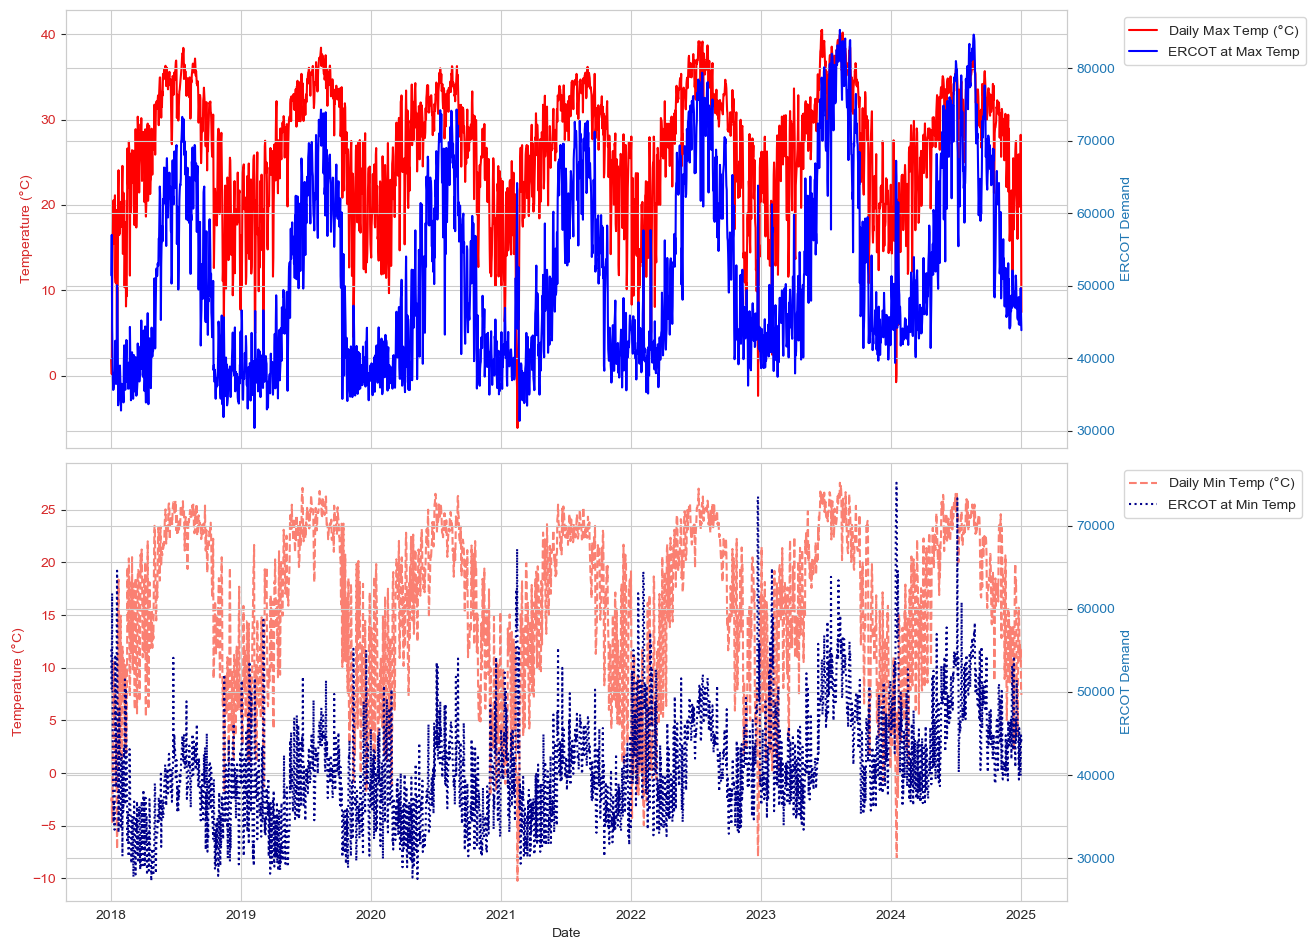

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for better aesthetics
sns.set_style("whitegrid")
# --- Plotting as Subplots ---

fig, (ax1_max, ax2_min) = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), sharex=True)
# fig.suptitle('Daily Temperature Extremes and Corresponding ERCOT Demand', fontsize=16)

# --- Subplot 1: Daily Max Temp and ERCOT at Max Temp ---
ax1_max.plot(final_daily_summary_with_ercot.index, final_daily_summary_with_ercot['Daily max tmpc'],
             label='Daily Max Temp ($\degree$C)', color='red')
ax1_max.set_ylabel('Temperature ($\degree$C)', color='tab:red')
ax1_max.tick_params(axis='y', labelcolor='tab:red')
# ax1_max.set_title('Daily Max Temperature and ERCOT Demand at Max Temp')
ax1_max.grid(True)

ax1_max_twin = ax1_max.twinx()
ax1_max_twin.plot(final_daily_summary_with_ercot.index, final_daily_summary_with_ercot['ERCOT at max tmpc'],
                  label='ERCOT at Max Temp', color='blue')
ax1_max_twin.set_ylabel('ERCOT Demand', color='tab:blue')
ax1_max_twin.tick_params(axis='y', labelcolor='tab:blue')

# Combined legend for the first subplot
lines, labels = ax1_max.get_legend_handles_labels()
lines_twin, labels_twin = ax1_max_twin.get_legend_handles_labels()
ax1_max_twin.legend(lines + lines_twin, labels + labels_twin, loc='best', bbox_to_anchor=(1.05, 1))


# --- Subplot 2: Daily Min Temp and ERCOT at Min Temp ---
ax2_min.plot(final_daily_summary_with_ercot.index, final_daily_summary_with_ercot['Daily min tmpc'],
             label='Daily Min Temp ($\degree$C)', color='salmon', linestyle='--')
ax2_min.set_xlabel('Date') # Only x-label on the bottom subplot
ax2_min.set_ylabel('Temperature ($\degree$C)', color='tab:red')
ax2_min.tick_params(axis='y', labelcolor='tab:red')
# ax2_min.set_title('Daily Min Temperature and ERCOT Demand at Min Temp')
ax2_min.grid(True)

ax2_min_twin = ax2_min.twinx()
ax2_min_twin.plot(final_daily_summary_with_ercot.index, final_daily_summary_with_ercot['ERCOT at min tmpc'],
                  label='ERCOT at Min Temp', color='darkblue', linestyle=':')
ax2_min_twin.set_ylabel('ERCOT Demand', color='tab:blue')
ax2_min_twin.tick_params(axis='y', labelcolor='tab:blue')

# Combined legend for the second subplot
lines, labels = ax2_min.get_legend_handles_labels()
lines_twin, labels_twin = ax2_min_twin.get_legend_handles_labels()
ax2_min_twin.legend(lines + lines_twin, labels + labels_twin, loc='best', bbox_to_anchor=(1.05, 1))
# plt.legend(title='Year', loc='best')

plt.savefig('Plots/Daily_Min_Max_Temperature_ERCOT.png', dpi=300, bbox_inches='tight')
plt.tight_layout(rect=[0, 0, 0.95, 0.96]) # Adjust rect for suptitle and side legends
# plt.xlim(datetime.datetime(2023,10,1), datetime.datetime(2023,12,1) )
plt.show()

<>:19: SyntaxWarning: invalid escape sequence '\d'
<>:20: SyntaxWarning: invalid escape sequence '\d'
<>:40: SyntaxWarning: invalid escape sequence '\d'
<>:42: SyntaxWarning: invalid escape sequence '\d'
<>:19: SyntaxWarning: invalid escape sequence '\d'
<>:20: SyntaxWarning: invalid escape sequence '\d'
<>:40: SyntaxWarning: invalid escape sequence '\d'
<>:42: SyntaxWarning: invalid escape sequence '\d'
C:\Users\sajib\AppData\Local\Temp\ipykernel_2196\1580131090.py:19: SyntaxWarning: invalid escape sequence '\d'
  label='Daily Max Temp ($\degree$C)', color='red')
C:\Users\sajib\AppData\Local\Temp\ipykernel_2196\1580131090.py:20: SyntaxWarning: invalid escape sequence '\d'
  ax1_max.set_ylabel('Temperature ($\degree$C)', color='tab:red')
C:\Users\sajib\AppData\Local\Temp\ipykernel_2196\1580131090.py:40: SyntaxWarning: invalid escape sequence '\d'
  label='Daily Min Temp ($\degree$C)', color='salmon', linestyle='--')
C:\Users\sajib\AppData\Local\Temp\ipykernel_2196\1580131090.py:42: Syn

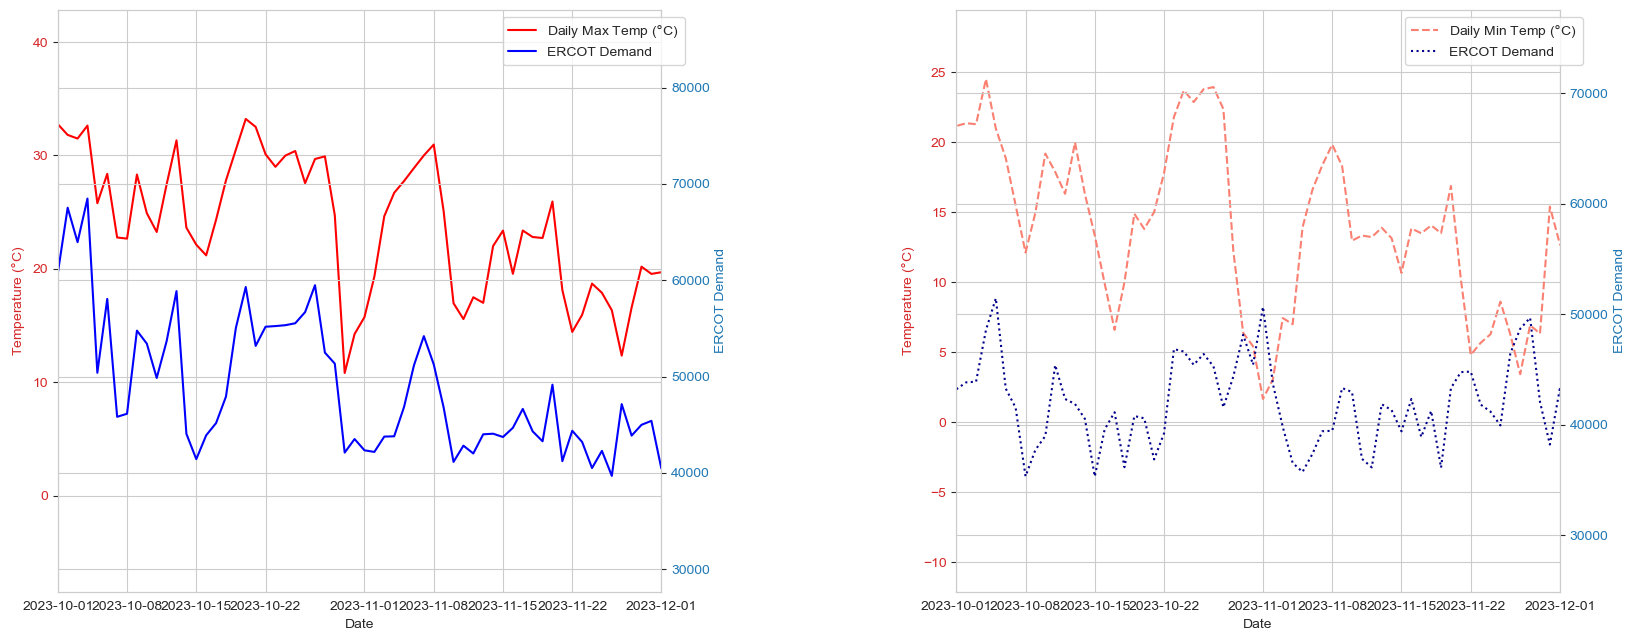

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime


# Set a style for better aesthetics
sns.set_style("whitegrid")

# --- Plotting as Subplots (Side-by-Side) ---

# Change nrows=2, ncols=1 to nrows=1, ncols=2 for side-by-side
fig, (ax1_max, ax2_min) = plt.subplots(nrows=1, ncols=2, figsize=(20, 7), sharey=False) # Increased figsize for side-by-side, sharey=False as scales might differ
# fig.suptitle('Daily Temperature Extremes and Corresponding ERCOT Demand', fontsize=16)


# --- Subplot 1 (Left): Daily Max Temp and ERCOT at Max Temp ---
ax1_max.plot(final_daily_summary_with_ercot.index, final_daily_summary_with_ercot['Daily max tmpc'],
             label='Daily Max Temp ($\degree$C)', color='red')
ax1_max.set_ylabel('Temperature ($\degree$C)', color='tab:red')
ax1_max.tick_params(axis='y', labelcolor='tab:red')
# ax1_max.set_title('Daily Max Temperature and ERCOT Demand') # Simplified title
ax1_max.grid(True)
ax1_max.set_xlabel('Date') # Add x-label for the left subplot

ax1_max_twin = ax1_max.twinx()
ax1_max_twin.plot(final_daily_summary_with_ercot.index, final_daily_summary_with_ercot['ERCOT at max tmpc'],
                 label='ERCOT Demand', color='blue') # Simplified label to avoid repetition
ax1_max_twin.set_ylabel('ERCOT Demand', color='tab:blue')
ax1_max_twin.tick_params(axis='y', labelcolor='tab:blue')

# Combined legend for the first subplot
lines, labels = ax1_max.get_legend_handles_labels()
lines_twin, labels_twin = ax1_max_twin.get_legend_handles_labels()
ax1_max_twin.legend(lines + lines_twin, labels + labels_twin, loc='best', bbox_to_anchor=(1.05, 1))


# --- Subplot 2 (Right): Daily Min Temp and ERCOT at Min Temp ---
ax2_min.plot(final_daily_summary_with_ercot.index, final_daily_summary_with_ercot['Daily min tmpc'],
             label='Daily Min Temp ($\degree$C)', color='salmon', linestyle='--')
ax2_min.set_xlabel('Date')
ax2_min.set_ylabel('Temperature ($\degree$C)', color='tab:red')
ax2_min.tick_params(axis='y', labelcolor='tab:red')
# ax2_min.set_title('Daily Min Temperature and ERCOT Demand') # Simplified title
ax2_min.grid(True)

ax2_min_twin = ax2_min.twinx()
ax2_min_twin.plot(final_daily_summary_with_ercot.index, final_daily_summary_with_ercot['ERCOT at min tmpc'],
                 label='ERCOT Demand', color='darkblue', linestyle=':') # Simplified label
ax2_min_twin.set_ylabel('ERCOT Demand', color='tab:blue')
ax2_min_twin.tick_params(axis='y', labelcolor='tab:blue')

# Combined legend for the second subplot
lines, labels = ax2_min.get_legend_handles_labels()
lines_twin, labels_twin = ax2_min_twin.get_legend_handles_labels()
ax2_min_twin.legend(lines + lines_twin, labels + labels_twin, loc='best', bbox_to_anchor=(1.05, 1))

# Adjust layout to prevent labels from overlapping and make space for legends
plt.tight_layout(rect=[0, 0, 0.9, 0.93]) # Adjusted rect for suptitle and side legends. The 0.9 (was 0.95) on rect[2] gives more space on the right.

# Set x-axis limits - apply to both subplots as they share the same x-axis values
# If you want independent x-limits, remove sharex=True from plt.subplots and set them individually
ax1_max.set_xlim(datetime.datetime(2023,10,1), datetime.datetime(2023,12,1))
ax2_min.set_xlim(datetime.datetime(2023,10,1), datetime.datetime(2023,12,1))

# plt.savefig('Plots/Daily_Min_Max_Temperature_ERCOT_SideBySide.png', dpi=300) # New filename
plt.show()

In [42]:
import pandas as pd

# Load your data from the CSV file
# Make sure the path is correct
try:
    df2 = pd.read_csv('Data/data_2018_2024.csv')
except FileNotFoundError:
    print("Error: The file 'Data/data_2018_2024.csv' was not found.")
    print("Please check the file path and ensure it's correct.")
    exit()

# --- Preprocessing Steps (as before, crucial for time-series analysis) ---
# Remove leading/trailing spaces from column names
df2.columns = df2.columns.str.strip()

# Ensure the 'timestamp' column is in datetime format
if 'timestamp' in df2.columns:
    df2['timestamp'] = pd.to_datetime(df2['timestamp'])
else:
    print("Error: 'timestamp' column not found after stripping spaces. Please check your CSV file.")
    exit()

# Set the 'timestamp' column as the DataFrame index
df2 = df2.set_index('timestamp')

# Define the features to process
features_to_process = ["tmpc", "relh", "sped", "feel"]

# --- 1. Daily Max and Min (already covered, but kept for completeness) ---
print("--- Daily Max and Min ---")
all_daily_stats = {}
for feature in features_to_process:
    if feature in df2.columns:
        daily_stats = df2[feature].resample('D').agg(['max', 'min'])
        daily_stats.rename(columns={'max': f'Daily max {feature}', 'min': f'Daily min {feature}'}, inplace=True)
        all_daily_stats[feature] = daily_stats
    else:
        print(f"Warning: Column '{feature}' not found in DataFrame. Skipping daily stats for it.")

if all_daily_stats:
    final_daily_summary = pd.concat([stats_df for stats_df in all_daily_stats.values()], axis=1)
    # print(final_daily_summary.head())
else:
    print("No daily statistics could be generated.")


# --- 2. Weekend (Saturday and Sunday) Max and Min ---
print("\n--- Weekend (Saturday & Sunday) Max and Min ---")
# Filter the DataFrame for weekends (Saturday=5, Sunday=6)
# dt.dayofweek returns 0 for Monday, 1 for Tuesday, ..., 6 for Sunday
df_weekends = df2[df2.index.dayofweek >= 5] # Filter for Saturday (5) and Sunday (6)

all_weekend_stats = {}
if not df_weekends.empty:
    for feature in features_to_process:
        if feature in df_weekends.columns:
            # Resample daily from the weekend data to get max/min for each weekend day
            weekend_daily_stats = df_weekends[feature].resample('D').agg(['max', 'min'])
            weekend_daily_stats.rename(columns={'max': f'Weekend Daily max {feature}', 'min': f'Weekend Daily min {feature}'}, inplace=True)
            all_weekend_stats[feature] = weekend_daily_stats
        else:
            print(f"Warning: Column '{feature}' not found in weekend DataFrame. Skipping weekend stats for it.")
    if all_weekend_stats:
        final_weekend_summary = pd.concat([stats_df for stats_df in all_weekend_stats.values()], axis=1)
        print(final_weekend_summary.head())
    else:
        print("No weekend statistics could be generated.")
else:
    print("No weekend data found in the DataFrame to calculate statistics.")


# --- 3. Weekly Max and Min ---
print("\n--- Weekly Max and Min ---")
all_weekly_stats = {}
for feature in features_to_process:
    if feature in df2.columns:
        # 'W' resamples to weekly frequency, typically ending on Sunday.
        # You can specify 'W-MON' for week ending Monday, etc.
        weekly_stats = df2[feature].resample('W').agg(['max', 'min'])
        weekly_stats.rename(columns={'max': f'Weekly max {feature}', 'min': f'Weekly min {feature}'}, inplace=True)
        all_weekly_stats[feature] = weekly_stats
    else:
        print(f"Warning: Column '{feature}' not found in DataFrame. Skipping weekly stats for it.")

if all_weekly_stats:
    final_weekly_summary = pd.concat([stats_df for stats_df in all_weekly_stats.values()], axis=1)
    # print(final_weekly_summary.head())
else:
    print("No weekly statistics could be generated.")


# --- 4. Monthly Max and Min ---
print("\n--- Monthly Max and Min ---")
all_monthly_stats = {}
for feature in features_to_process:
    if feature in df2.columns:
        # 'M' resamples to monthly frequency, typically ending on the last day of the month.
        monthly_stats = df2[feature].resample('M').agg(['max', 'min'])
        monthly_stats.rename(columns={'max': f'Monthly max {feature}', 'min': f'Monthly min {feature}'}, inplace=True)
        all_monthly_stats[feature] = monthly_stats
    else:
        print(f"Warning: Column '{feature}' not found in DataFrame. Skipping monthly stats for it.")

if all_monthly_stats:
    final_monthly_summary = pd.concat([stats_df for stats_df in all_monthly_stats.values()], axis=1)
    # print(final_monthly_summary.head())
else:
    print("No monthly statistics could be generated.")

--- Daily Max and Min ---

--- Weekend (Saturday & Sunday) Max and Min ---
            Weekend Daily max tmpc  Weekend Daily min tmpc  \
timestamp                                                    
2018-01-06               19.604444                2.740000   
2018-01-07               20.536667               10.592222   
2018-01-08                     NaN                     NaN   
2018-01-09                     NaN                     NaN   
2018-01-10                     NaN                     NaN   

            Weekend Daily max relh  Weekend Daily min relh  \
timestamp                                                    
2018-01-06               93.530000               49.413333   
2018-01-07               89.266667               57.270000   
2018-01-08                     NaN                     NaN   
2018-01-09                     NaN                     NaN   
2018-01-10                     NaN                     NaN   

            Weekend Daily max sped  Weekend Daily min s

C:\Users\sajib\AppData\Local\Temp\ipykernel_2196\1966664292.py:98: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_stats = df2[feature].resample('M').agg(['max', 'min'])


In [43]:
final_monthly_summary

,Monthly max tmpc,Monthly min tmpc,Monthly max relh,Monthly min relh,Monthly max sped,Monthly min sped,Monthly max feel,Monthly min feel
timestamp,,,,,,,,
2018-01-31,24.055556,-7.210000,96.263333,10.863333,23.127778,0.000000,75.747778,16.056667
2018-02-28,27.401111,1.888889,96.150000,27.296667,21.338889,0.000000,82.496667,29.003333
2018-03-31,30.332222,5.666667,95.930000,11.600000,19.038889,0.000000,86.872222,40.483889
2018-04-30,29.518889,5.345556,95.003333,9.316667,19.294444,0.000000,86.816667,38.571111
2018-05-31,35.870000,14.491667,95.050000,15.846667,15.908333,0.000000,102.582222,58.066667
...,...,...,...,...,...,...,...,...
2024-09-30,35.666667,15.666667,100.000000,32.346667,17.122222,0.000000,101.883333,60.500000
2024-10-31,34.172222,8.784444,100.000000,20.580000,18.208333,0.000000,97.683333,49.377778
2024-11-30,31.241667,5.028333,100.000000,11.760000,20.700000,0.000000,96.241667,39.411667


In [44]:
import pandas as pd

# Load your data from the CSV file
# Make sure the path is correct
try:
    df2 = pd.read_csv('Data/data_2018_2024.csv')
except FileNotFoundError:
    print("Error: The file 'Data/data_2018_2024.csv' was not found.")
    print("Please check the file path and ensure it's correct.")
    exit()

# --- Preprocessing Steps ---
# Remove leading/trailing spaces from column names
df2.columns = df2.columns.str.strip()

# Ensure the 'timestamp' column is in datetime format
if 'timestamp' in df2.columns:
    df2['timestamp'] = pd.to_datetime(df2['timestamp'])
else:
    print("Error: 'timestamp' column not found after stripping spaces. Please check your CSV file.")
    exit()

# Set the 'timestamp' column as the DataFrame index
df2 = df2.set_index('timestamp')

# Define the features to process
features_to_process = ["tmpc", "relh", "sped", "feel"]

# --- Helper function to calculate max/min of a feature and ERCOT at those times ---
def calculate_extreme_stats_with_ercot(dataframe, features, freq_code, prefix_name):
    """
    Calculates max/min for specified features and the corresponding ERCOT value
    at the time of those extremes, for a given frequency.
    """
    all_stats_combined = [] # List to store results for each feature

    # Get the groups based on the frequency
    # For 'D', 'W', 'M', we can use .floor() to get the start of the period
    # For 'M' specifically, use 'ME' for month-end (or 'MS' for month-start)
    # The warning suggests 'ME' for 'M'.
    if freq_code == 'M':
        # Use Grouper for more flexible grouping by frequency
        grouped = dataframe.groupby(pd.Grouper(freq='ME'))
    elif freq_code == 'W':
        grouped = dataframe.groupby(pd.Grouper(freq='W'))
    elif freq_code == 'D':
        grouped = dataframe.groupby(pd.Grouper(freq='D'))
    else:
        # Fallback for other single-letter frequencies or error handling
        grouped = dataframe.groupby(pd.Grouper(freq=freq_code))


    for feature in features:
        if feature in dataframe.columns and 'ERCOT' in dataframe.columns:
            
            period_max_values = []
            period_min_values = []
            ercot_at_period_max = []
            ercot_at_period_min = []
            period_indices = [] # To store the actual period labels (e.g., dates, week-ends, month-ends)

            for period_label, group in grouped:
                if not group.empty:
                    period_indices.append(period_label)

                    # Find max value and its original timestamp (index)
                    max_value_in_group = group[feature].max()
                    idx_max_in_group = group[feature].idxmax() # Original timestamp
                    
                    # Find min value and its original timestamp (index)
                    min_value_in_group = group[feature].min()
                    idx_min_in_group = group[feature].idxmin() # Original timestamp
                    
                    period_max_values.append(max_value_in_group)
                    period_min_values.append(min_value_in_group)
                    
                    # Retrieve ERCOT value at the exact timestamp of max/min
                    ercot_at_period_max.append(group.loc[idx_max_in_group, 'ERCOT'])
                    ercot_at_period_min.append(group.loc[idx_min_in_group, 'ERCOT'])
                else:
                    # Append NaNs if group is empty (no data for that period)
                    period_indices.append(period_label)
                    period_max_values.append(pd.NA)
                    period_min_values.append(pd.NA)
                    ercot_at_period_max.append(pd.NA)
                    ercot_at_period_min.append(pd.NA)


            # Create a temporary DataFrame for this feature's stats
            feature_result_df = pd.DataFrame({
                f'{prefix_name} max {feature}': period_max_values,
                f'ERCOT at {prefix_name} max {feature}': ercot_at_period_max,
                f'{prefix_name} min {feature}': period_min_values,
                f'ERCOT at {prefix_name} min {feature}': ercot_at_period_min
            }, index=period_indices)
            
            all_stats_combined.append(feature_result_df)
        else:
            print(f"Warning: Column '{feature}' or 'ERCOT' not found. Skipping {feature} for {prefix_name} stats.")

    if all_stats_combined:
        # Concatenate all feature-specific dataframes side-by-side
        return pd.concat(all_stats_combined, axis=1).dropna(how='all') # Drop rows with all NaNs
    return pd.DataFrame()


# --- ONLY Monthly Max and Min with corresponding ERCOT ---
print("--- Monthly Max and Min with ERCOT ---")
# Use 'ME' for Month End frequency to resolve the FutureWarning
final_monthly_summary_with_ercot = calculate_extreme_stats_with_ercot(df2, features_to_process, 'ME', 'Monthly')
if not final_monthly_summary_with_ercot.empty:
    print(final_monthly_summary_with_ercot.head())
    # You can now use final_monthly_summary_with_ercot for further analysis or plotting
    # For example, to save it to a CSV:
    # final_monthly_summary_with_ercot.to_csv('monthly_summary_with_ercot.csv')
else:
    print("No monthly statistics with ERCOT could be generated.")

--- Monthly Max and Min with ERCOT ---
            Monthly max tmpc  ERCOT at Monthly max tmpc  Monthly min tmpc  \
2018-01-31         24.055556               34240.576519         -7.210000   
2018-02-28         27.401111               39417.172629          1.888889   
2018-03-31         30.332222               42055.871436          5.666667   
2018-04-30         29.518889               46239.991581          5.345556   
2018-05-31         35.870000               66319.718821         14.491667   

            ERCOT at Monthly min tmpc  Monthly max relh  \
2018-01-31               64579.617548         96.263333   
2018-02-28               44728.796390         96.150000   
2018-03-31               36827.298504         95.930000   
2018-04-30               33271.595168         95.003333   
2018-05-31               31227.951457         95.050000   

            ERCOT at Monthly max relh  Monthly min relh  \
2018-01-31               31360.135713         10.863333   
2018-02-28               

In [45]:
final_monthly_summary_with_ercot

,Monthly max tmpc,ERCOT at Monthly max tmpc,Monthly min tmpc,ERCOT at Monthly min tmpc,Monthly max relh,ERCOT at Monthly max relh,Monthly min relh,ERCOT at Monthly min relh,Monthly max sped,ERCOT at Monthly max sped,Monthly min sped,ERCOT at Monthly min sped,Monthly max feel,ERCOT at Monthly max feel,Monthly min feel,ERCOT at Monthly min feel
2018-01-31,24.055556,34240.576519,-7.210000,64579.617548,96.263333,31360.135713,10.863333,44374.213207,23.127778,43339.300186,0.000000,49544.063188,75.747778,34240.576519,16.056667,58701.537029
2018-02-28,27.401111,39417.172629,1.888889,44728.796390,96.150000,29246.582497,27.296667,35778.117450,21.338889,39198.432750,0.000000,30989.575417,82.496667,39417.172629,29.003333,46216.008489
2018-03-31,30.332222,42055.871436,5.666667,36827.298504,95.930000,27997.555753,11.600000,41535.044156,19.038889,35782.608436,0.000000,31184.839289,86.872222,41687.598612,40.483889,36827.298504
2018-04-30,29.518889,46239.991581,5.345556,33271.595168,95.003333,28063.147410,9.316667,33684.630416,19.294444,39298.530442,0.000000,31261.906088,86.816667,44404.389098,38.571111,31243.147410
2018-05-31,35.870000,66319.718821,14.491667,31227.951457,95.050000,34676.269677,15.846667,57428.676418,15.908333,50100.031408,0.000000,28104.557552,102.582222,64511.852315,58.066667,31227.951457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-30,35.666667,77643.917038,15.666667,42418.560569,100.000000,49131.300572,32.346667,68790.424298,17.122222,59366.552185,0.000000,59001.866489,101.883333,75088.653627,60.500000,42418.560569
2024-10-31,34.172222,68918.617330,8.784444,42577.477765,100.000000,43430.802737,20.580000,63919.658229,18.208333,61572.791675,0.000000,48414.501322,97.683333,60911.116550,49.377778,37979.573522
2024-11-30,31.241667,54989.293448,5.028333,43786.803921,100.000000,46961.917591,11.760000,50301.739416,20.700000,51689.312825,0.000000,44773.662525,96.241667,54989.293448,39.411667,43786.803921
2024-12-31,28.207778,49695.742242,2.278333,54271.330056,100.000000,49244.733629,12.490000,44594.422746,17.058333,49931.464616,0.000000,43877.381132,83.916667,51321.150035,31.738333,54271.330056


In [46]:
import pandas as pd

# Load your data from the CSV file
# Make sure the path is correct
try:
    df2 = pd.read_csv('Data/data_2018_2024.csv')
except FileNotFoundError:
    print("Error: The file 'Data/data_2018_2024.csv' was not found.")
    print("Please check the file path and ensure it's correct.")
    exit()

# --- Preprocessing Steps ---
# Remove leading/trailing spaces from column names
df2.columns = df2.columns.str.strip()

# Ensure the 'timestamp' column is in datetime format
if 'timestamp' in df2.columns:
    df2['timestamp'] = pd.to_datetime(df2['timestamp'])
else:
    print("Error: 'timestamp' column not found after stripping spaces. Please check your CSV file.")
    exit()

# Set the 'timestamp' column as the DataFrame index
df2 = df2.set_index('timestamp')

# --- Average ERCOT data monthly for each year ---
# Resample the 'ERCOT' column to a monthly frequency ('ME' for Month End)
# and then calculate the mean for each month.
monthly_average_ercot = df2['ERCOT'].resample('ME').mean()

# print("--- Monthly Average ERCOT Demand for Each Year ---")
# print(monthly_average_ercot.head(12)) # Display first 12 months to show yearly progression
# print("...")
# print(monthly_average_ercot.tail(12)) # Display last 12 months

# You can also get a specific year's monthly averages, for example, 2020:
# print("\nMonthly ERCOT Averages for 2020:")
# print(monthly_average_ercot['2020'])

# To save this monthly average data to a new CSV file:
# monthly_average_ercot.to_csv('monthly_average_ercot.csv')

In [47]:
monthly_average_ercot

timestamp
2018-01-31    42043.886225
2018-02-28    38316.776082
2018-03-31    35201.750977
2018-04-30    35742.517567
2018-05-31    45302.430950
                  ...     
2024-09-30    56946.961243
2024-10-31    52726.747068
2024-11-30    46825.013582
2024-12-31    46897.347034
2025-01-31    43892.434849
Freq: ME, Name: ERCOT, Length: 85, dtype: float64

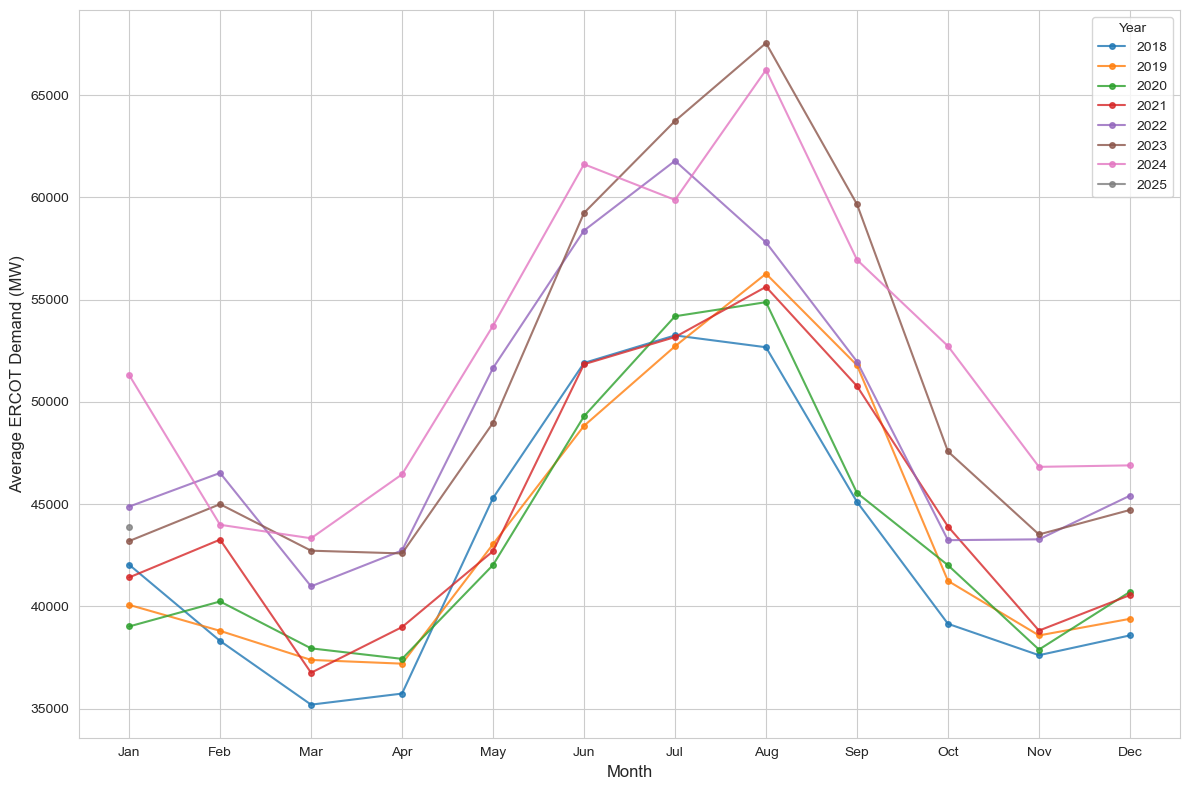

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for better aesthetics
sns.set_style("whitegrid")

# --- Restructure data for plotting each year as a separate line ---

# Create a DataFrame from the monthly_average_ercot Series
df_monthly_avg = monthly_average_ercot.reset_index()
df_monthly_avg.columns = ['Date', 'Average ERCOT Demand']

# Extract Year and Month as separate columns
df_monthly_avg['Year'] = df_monthly_avg['Date'].dt.year
df_monthly_avg['Month'] = df_monthly_avg['Date'].dt.month

# Pivot the table: months as index, years as columns, ERCOT demand as values
# This creates a DataFrame where each column is a year and each row is a month
pivot_table_ercot = df_monthly_avg.pivot_table(index='Month', columns='Year', values='Average ERCOT Demand')


# --- Plotting each year as a separate line ---
plt.figure(figsize=(12, 8))

# Plotting directly from the pivoted DataFrame
# Each column (year) will be a separate line
pivot_table_ercot.plot(ax=plt.gca(), marker='o', markersize=4, alpha=0.8)

# plt.title('Monthly Average ERCOT Demand by Year (2018-2024)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average ERCOT Demand (MW)', fontsize=12)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
# plt.legend(title='Year', bbox_to_anchor=(1.02, 1), loc='upper left') # Legend outside the plot
plt.legend(title='Year', loc='best')
plt.grid(True)
plt.savefig('Plots/Monthly Average ERCOT Demand.png', dpi=300, bbox_inches='tight')
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

C:\Users\sajib\AppData\Local\Temp\ipykernel_2196\1436944715.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_df, x='Category', y='ERCOT_Demand', order=category_order, palette='viridis')


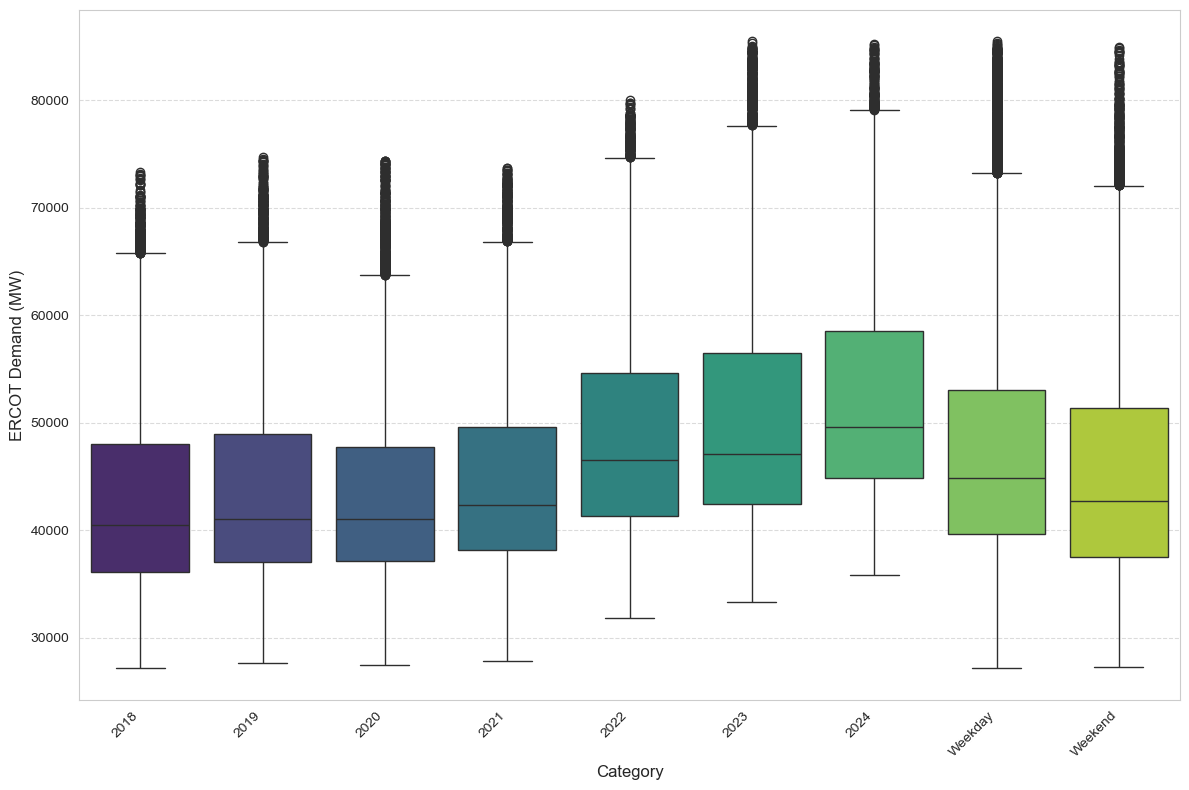

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for better aesthetics
sns.set_style("whitegrid")

# --- Load and preprocess the data ---
# IMPORTANT: Ensure 'Data/data_2018_2024.csv' is in the correct directory
# relative to where you are running this script, or provide the full path.
try:
    df2 = pd.read_csv('Data/data_2018_2024.csv')
except FileNotFoundError:
    print("Error: The file 'Data/data_2018_2024.csv' was not found.")
    print("Please ensure the file path is correct and the file is accessible.")
    exit() # Exit if the file cannot be loaded

df2.columns = df2.columns.str.strip() # Remove any leading/trailing spaces from column names

if 'timestamp' in df2.columns:
    df2['timestamp'] = pd.to_datetime(df2['timestamp'])
else:
    print("Error: 'timestamp' column not found after stripping spaces. Please check your CSV file.")
    exit() # Exit if the timestamp column is missing

df2 = df2.set_index('timestamp') # Set the timestamp column as the DataFrame index

# --- Prepare data for box plots ---
all_ercot_data = []

# Data for each year
years = range(2018, 2025) # This range includes 2018 up to (but not including) 2025, so it covers 2018, 2019, 2020, 2021, 2022, 2023, 2024
for year in years:
    # Use .loc with string slicing for the year to filter data for that specific year
    # .copy() is used to avoid SettingWithCopyWarning
    year_data = df2.loc[str(year), 'ERCOT'].copy()
    year_data = year_data.to_frame(name='ERCOT_Demand') # Convert Series to DataFrame for concatenation
    year_data['Category'] = str(year) # Add a 'Category' column to label the data source
    all_ercot_data.append(year_data)

# Data for Weekday vs. Weekend
# df.index.dayofweek returns 0 for Monday, 1 for Tuesday, ..., 6 for Sunday
df_weekdays = df2[df2.index.dayofweek < 5]['ERCOT'].copy() # Weekdays are 0, 1, 2, 3, 4
df_weekdays = df_weekdays.to_frame(name='ERCOT_Demand')
df_weekdays['Category'] = 'Weekday'
all_ercot_data.append(df_weekdays)

df_weekends = df2[df2.index.dayofweek >= 5]['ERCOT'].copy() # Weekends are 5, 6
df_weekends = df_weekends.to_frame(name='ERCOT_Demand')
df_weekends['Category'] = 'Weekend'
all_ercot_data.append(df_weekends)

# Concatenate all individual DataFrames into a single DataFrame for plotting with Seaborn
plot_df = pd.concat(all_ercot_data)

# Define the order of categories on the x-axis for the plot
category_order = [str(year) for year in years] + ['Weekday', 'Weekend']

# --- Create the Box Plot ---
plt.figure(figsize=(12, 8)) # Adjust figure size for better readability and to accommodate all categories

sns.boxplot(data=plot_df, x='Category', y='ERCOT_Demand', order=category_order, palette='viridis')

# plt.title('ERCOT Demand Distribution by Year, Weekday, and Weekend', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('ERCOT Demand (MW)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add horizontal grid lines for easier value comparison

plt.xticks(rotation=45, ha='right') # Rotate x-axis labels to prevent overlap
plt.tight_layout() # Adjust layout to ensure all elements fit without overlapping
plt.savefig('Plots/box_map.png', dpi=300, bbox_inches='tight')
plt.show()

DataFrame 'df' found. Using existing DataFrame.


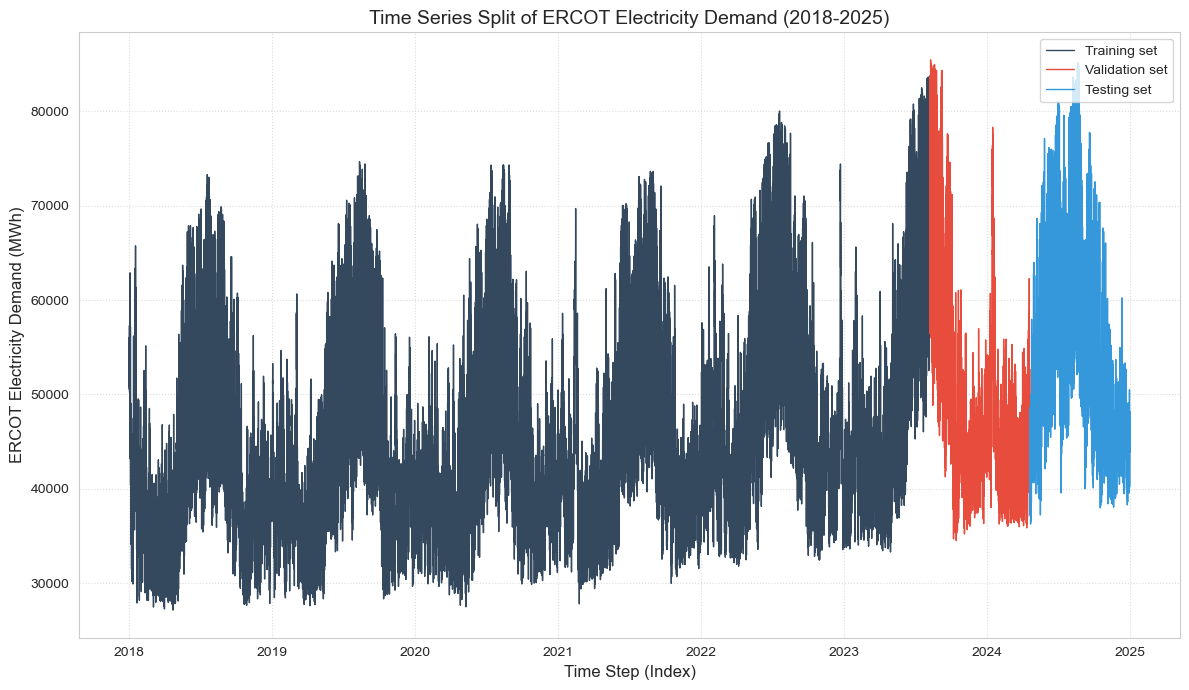

In [50]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm
import seaborn as sns

# Ensure df is created, either by loading or by dummy data
try:
    _ = df.head() # Try to access to see if it exists
    print("DataFrame 'df' found. Using existing DataFrame.")
except NameError:
    print("DataFrame 'df' not found. Creating dummy data for plotting demonstration.")
    # Create dummy dataframes for demonstration if not already defined
    try:
        df = pd.read_csv('Data/data_2018_2024.csv')
        print("Loaded 'Data/data_2018_2024.csv'.")
    except FileNotFoundError:
        print("Error: 'Data/data_2018_2024.csv' not found. Creating a mock dataframe.")
        # Create a mock dataframe for demonstration if file not found
        dates = pd.date_range(start='2018-01-01', periods=61368, freq='H')
        np.random.seed(42)
        ercot_demand = np.random.normal(350000, 50000, 61368) # Mean 350k, std 50k
        ercot_demand = np.maximum(200000, ercot_demand) # Ensure positive values
        df = pd.DataFrame({'timestamp': dates, 'ERCOT': ercot_demand})

# Now, ensure train_df, val_df, and test_df are always created after df is defined
total_rows = len(df)
train_size = int(total_rows * 0.8)
val_size = int(total_rows * 0.1)
test_size = total_rows - train_size - val_size

train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size + val_size]
test_df = df.iloc[train_size + val_size:]


# Set a seaborn style for better aesthetics
sns.set_style("whitegrid")
sns.set_palette("muted") # Choose a pleasant color palette

# --- Plot (a): Time Series Split Visualization (Enhanced) ---
plt.figure(figsize=(12, 7)) # Slightly larger figure
plt.plot(train_df.index, train_df['ERCOT'], label='Training set', color='#34495E', linewidth=1.0) # Darker, professional gray
plt.plot(val_df.index, val_df['ERCOT'], label='Validation set', color='#E74C3C', linewidth=1.0) # Vibrant red
plt.plot(test_df.index, test_df['ERCOT'], label='Testing set', color='#3498DB', linewidth=1.0) # Clear blue

plt.xlabel('Time Step (Index)', fontsize=12) # More generic label, as index is abstract
plt.ylabel('ERCOT Electricity Demand (MWh)', fontsize=12) # Specific and professional label
plt.title('Time Series Split of ERCOT Electricity Demand (2018-2025)', fontsize=14)
plt.legend(fontsize=10, loc='upper right')
plt.grid(True, linestyle=':', alpha=0.7) # Dotted grid lines
plt.tight_layout()
plt.savefig('Plots/Time_Series_Split.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\sajib\AppData\Local\Temp\ipykernel_2196\4270894365.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Set', y='ERCOT', data=all_data_for_boxplot, palette='viridis',
C:\Users\sajib\AppData\Local\Temp\ipykernel_2196\4270894365.py:13: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.boxplot(x='Set', y='ERCOT', data=all_data_for_boxplot, palette='viridis',
C:\Users\sajib\AppData\Local\Temp\ipykernel_2196\4270894365.py:17: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(x='Set', y='ERCOT', data=all_data_for_boxplot,


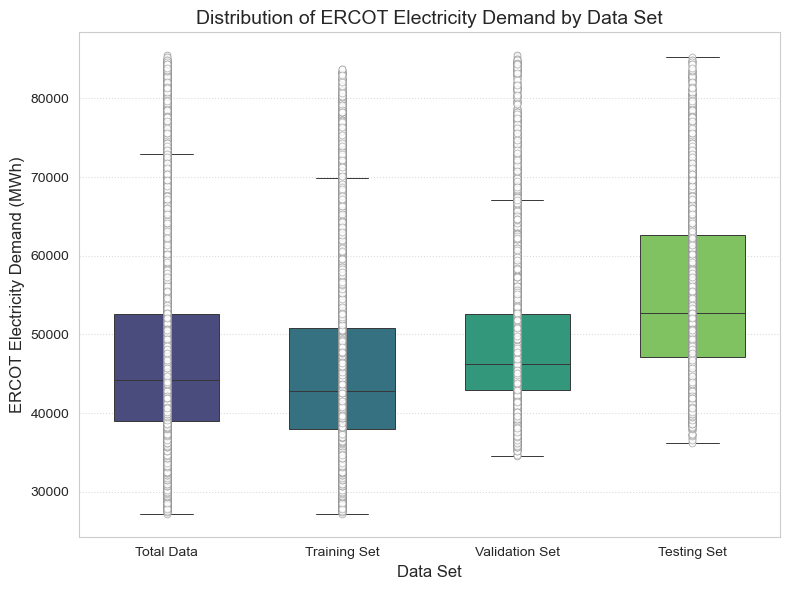

In [52]:
# --- Plot (b): Box Plots for Each Set (Enhanced) ---
plt.figure(figsize=(8, 6))

# Concatenate all data with a 'Set' column for easy plotting with seaborn
all_data_for_boxplot = pd.concat([
    pd.DataFrame({'ERCOT': df['ERCOT'], 'Set': 'Total Data'}),
    pd.DataFrame({'ERCOT': train_df['ERCOT'], 'Set': 'Training Set'}),
    pd.DataFrame({'ERCOT': val_df['ERCOT'], 'Set': 'Validation Set'}),
    pd.DataFrame({'ERCOT': test_df['ERCOT'], 'Set': 'Testing Set'})
])

# Use seaborn boxplot for better aesthetics
sns.boxplot(x='Set', y='ERCOT', data=all_data_for_boxplot, palette='viridis',
            width=0.6, linecolor='gray', linewidth=0.7, showcaps=True,
            flierprops=dict(marker='o', markersize=4, linestyle='none', alpha=0.6))
# Add mean markers
sns.stripplot(x='Set', y='ERCOT', data=all_data_for_boxplot,
              color='white', edgecolor='gray', linewidth=0.5, marker='o', size=5,
              jitter=False, alpha=0.8, dodge=True,
              ax=plt.gca()) # Plot mean as a single point

plt.xlabel('Data Set', fontsize=12)
plt.ylabel('ERCOT Electricity Demand (MWh)', fontsize=12)
plt.title('Distribution of ERCOT Electricity Demand by Data Set', fontsize=14)
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.tight_layout()
plt.savefig('Plots/Time_Series_Split_box_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [53]:
# --- Plots (a), (b), (c), (e): Histograms with Fitted Normal Distribution (Enhanced) ---

# Define a function to plot histogram with fitted normal distribution
def plot_histogram_with_normal_enhanced(ax, data, title, xlabel_text):
    # Use seaborn's histplot for a nicer histogram base
    sns.histplot(data, bins=50, kde=False, stat="count", ax=ax, color='#E74C3C', edgecolor='white', alpha=0.8) # Vibrant red bars

    # Fit a normal distribution to the data
    mu, std = norm.fit(data)

    # Plot the PDF of the normal distribution
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std) * len(data) * (data.max() - data.min()) / 50 # Scale PDF to match histogram bars (adjust scaling factor based on bins)
    # A more robust scaling factor for PDF might be `len(data) * bin_width` where bin_width is `(data.max() - data.min()) / num_bins`
    # Let's approximate bin_width as (xmax - xmin) / number_of_bins_used_in_histplot
    bin_width = (xmax - xmin) / 50 # Assuming 50 bins as specified
    p = norm.pdf(x, mu, std) * len(data) * bin_width

    ax.plot(x, p, color='#3498DB', linestyle='--', linewidth=2.5, alpha=0.7, label=f'Normal Fit ($\mu$={mu:,.0f}, $\sigma$={std:,.0f})') # Blue curve, more prominent

    ax.set_title(title, fontsize=13)
    ax.set_xlabel(xlabel_text, fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.ticklabel_format(style='plain', axis='x') # Prevent scientific notation on x-axis if values are large
    ax.legend(fontsize=9, loc='upper right')
    ax.grid(axis='y', linestyle=':', alpha=0.7) # Dotted grid lines

<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\s'
C:\Users\sajib\AppData\Local\Temp\ipykernel_2196\2586457454.py:20: SyntaxWarning: invalid escape sequence '\m'
  ax.plot(x, p, color='#3498DB', linestyle='--', linewidth=2.5, alpha=0.7, label=f'Normal Fit ($\mu$={mu:,.0f}, $\sigma$={std:,.0f})') # Blue curve, more prominent
C:\Users\sajib\AppData\Local\Temp\ipykernel_2196\2586457454.py:20: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(x, p, color='#3498DB', linestyle='--', linewidth=2.5, alpha=0.7, label=f'Normal Fit ($\mu$={mu:,.0f}, $\sigma$={std:,.0f})') # Blue curve, more prominent


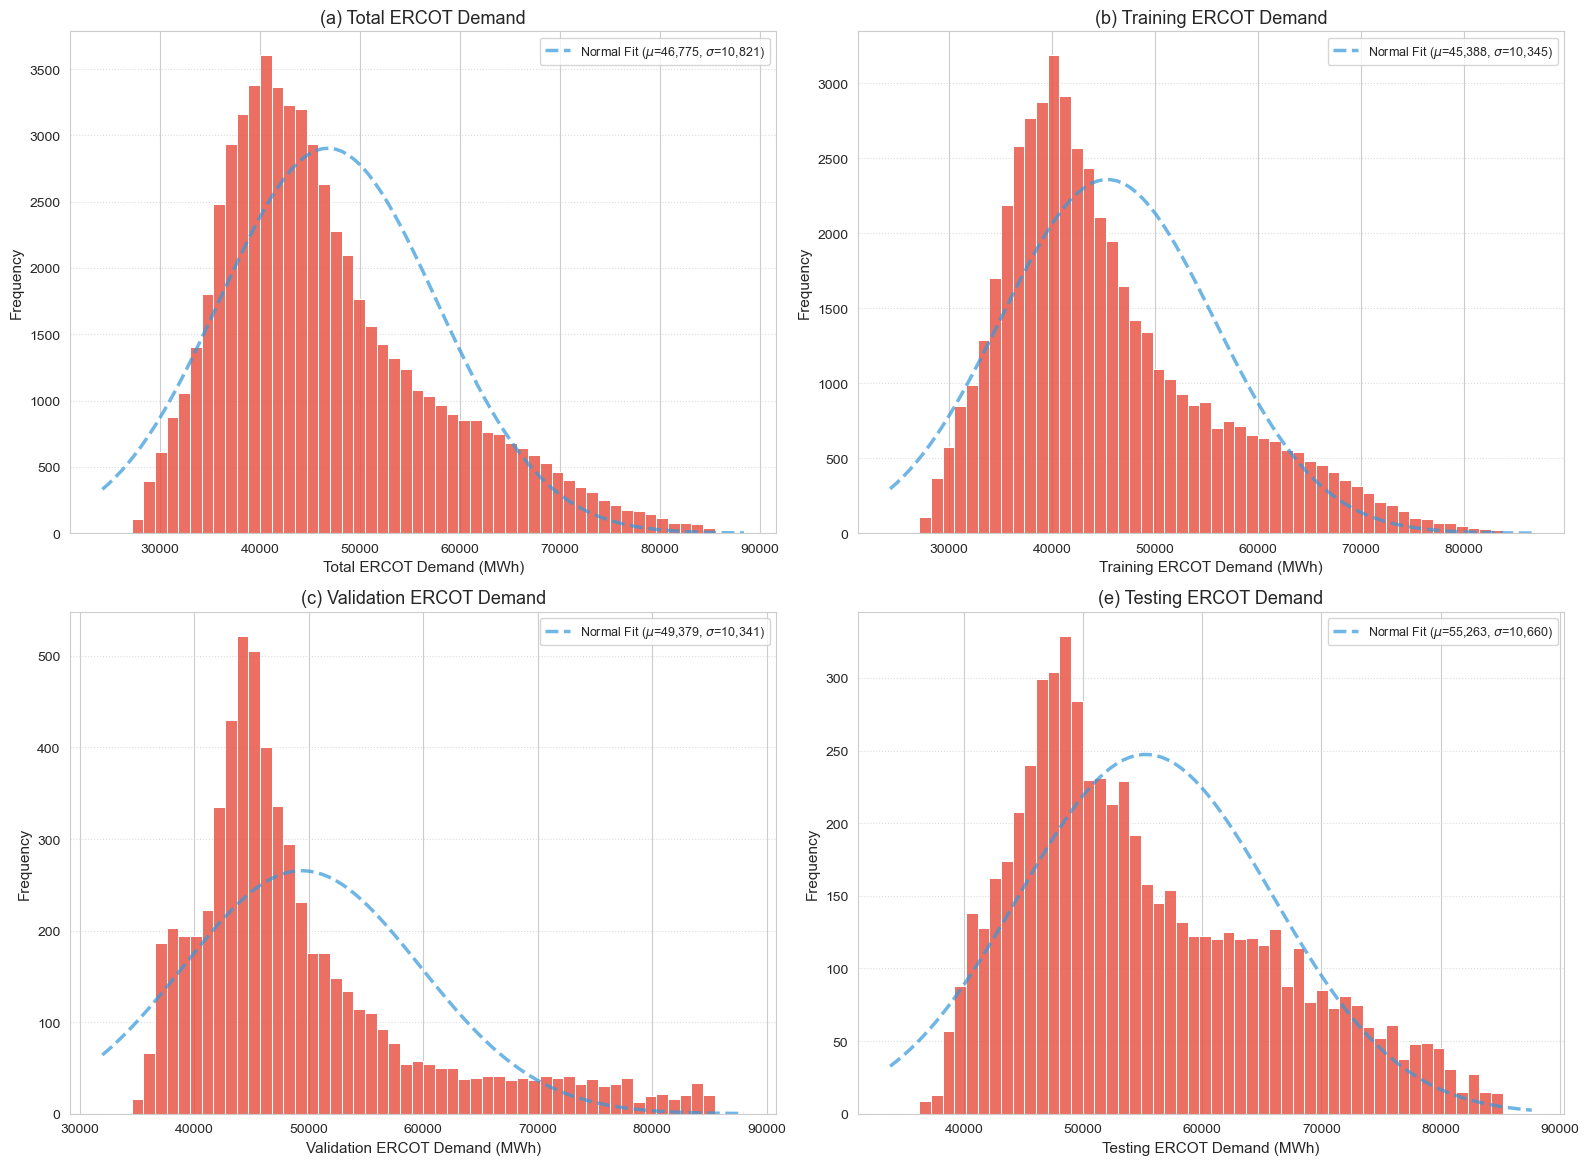

In [54]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12)) # Larger overall figure
# fig.suptitle('Distribution of ERCOT Electricity Demand Across Data Sets', fontsize=16, y=1.02, weight='bold') # Overall title, bold

# Plot (c): Total ERCOT Demand
plot_histogram_with_normal_enhanced(axes[0, 0], df['ERCOT'], '(a) Total ERCOT Demand', 'Total ERCOT Demand (MWh)')

# Plot (d): Training Demand
plot_histogram_with_normal_enhanced(axes[0, 1], train_df['ERCOT'], '(b) Training ERCOT Demand', 'Training ERCOT Demand (MWh)')

# Plot (e): Validation Demand
plot_histogram_with_normal_enhanced(axes[1, 0], val_df['ERCOT'], '(c) Validation ERCOT Demand', 'Validation ERCOT Demand (MWh)')

# Plot (f): Testing Demand
plot_histogram_with_normal_enhanced(axes[1, 1], test_df['ERCOT'], '(e) Testing ERCOT Demand', 'Testing ERCOT Demand (MWh)')

plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to prevent title overlap
plt.savefig('Plots/Time_Series_Split_Frequency.png', dpi=300, bbox_inches='tight')
plt.show()